In [120]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
import matplotlib
from astroquery.simbad import Simbad
from astroquery.ipac.ned import Ned
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

# **Function Definitions**

In [121]:
def query_ned(objname):
    result_table = Ned.query_object(objname)
    ra = result_table['RA'][0]
    dec = result_table['DEC'][0]
    ra_start = round(ra - 0.6, 2)
    ra_end = round(ra + 0.6, 2)
    dec_start = round(dec - 0.6, 2)
    dec_end = round(dec + 0.6, 2)
    return ra_start, ra_end, dec_start, dec_end

In [122]:
def query_gaia(objname='', parallax_start = 0, parralax_end = 10000, 
          pmra_start = -1000, pmra_end = 1000,
          pmdec_start = -1000, pmdec_end = 1000, ra=0., dec=0.):
    try:
        ra_start, ra_end, dec_start, dec_end = query_ned(objname)
    except:
        ra_start = ra - 0.6
        ra_end = ra + 0.6
        dec_start = dec - 0.6
        dec_end = dec + 0.6
      # Query Gaia database
    query = '''SELECT top 10000 \
    source_id, ra, dec, parallax, phot_g_mean_mag, \
    phot_bp_mean_mag, phot_rp_mean_mag, pmra, pmdec, radial_velocity \
    FROM gaiadr3.gaia_source \
    WHERE ra between {} and {} \
    AND dec between {} and {} \
    AND abs(pmra_error/pmra)<0.10 \
    AND abs(pmdec_error/pmdec)<0.10 \
    and parallax_over_error > 10 \
    and parallax between {} and {} \
    and pmra between {} and {} \
    and pmdec between {} and {} \
    order by parallax desc'''.format(ra_start, ra_end, dec_start, dec_end, 
                                 parallax_start, parralax_end, pmra_start, 
                                 pmra_end, pmdec_start, pmdec_end)
    job = Gaia.launch_job_async(query)
    r = job.get_results()
    return r

In [123]:
def plot_appmag_vs_dist(objname, r):
    dist = 1000/r['parallax']
    appmag = r['phot_g_mean_mag']
    plt.figure(figsize=(8,5), dpi=200)
    plt.scatter(np.log10(dist), appmag, s=0.3, c='slateblue')
    plt.xlabel('log$_{10}$[Distance] (parsecs)')
    plt.title(f'Apparent Magnitude vs Distance for {objname}', pad=10, fontsize=15)
    plt.ylabel('Apparent Magnitude in G band')
    return dist

In [124]:
def gauss(x, A, m, s, c):
    return A*np.exp(-(x-m)**2/(2*s**2)) + c

In [125]:
def gauss_fit(objname, dist):
    n, bins = np.histogram(dist, bins=100)
    bins = [0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)]
    p0 = [max(n), np.mean(dist), np.std(dist), 50]
    popt, pcov = curve_fit(gauss, bins, n, p0=p0)
    x = np.linspace(min(bins), max(bins), 200)
    plt.figure(figsize=(8,5), dpi=200)
    plt.plot(x, gauss(x, *popt), color = 'salmon', label='Gaussian Fit')
    plt.hist(dist, bins=100, label='Data', color='slateblue')
    plt.title(f'Distance Distribution of {objname}', pad=10, fontsize=15)
    plt.legend()
    return popt

In [126]:
def parallax_cut(dist, popt):
    dist = dist[np.logical_and(dist>(popt[1]-3*np.abs(popt[2])), dist<(popt[1]+3*np.abs(popt[2])))]
    parallax_start = 1000/np.max(dist)
    parallax_end = 1000/np.min(dist)
    return parallax_start, parallax_end

In [127]:
def plot_pm(objname, parallax_start, parallax_end, clip=0.5, ra=0., dec=0.):
    r = query_gaia(objname, parallax_start=parallax_start, parralax_end=parallax_end, ra=ra, dec=dec)
    mean_ra = np.mean(r['pmra'])
    mean_dec = np.mean(r['pmdec'])
    xlim = (mean_ra-10, mean_ra+10)
    ylim = (mean_dec-7, mean_dec+7)
    vel = np.sqrt((r['pmra']-mean_ra)**2 + (r['pmdec']-mean_dec)**2)
    std_vel = np.std(vel, ddof=1)
    r = r[vel < clip*std_vel]
    plt.figure(figsize=(8,5), dpi=200)
    plt.scatter(r['pmra'], r['pmdec'], s=0.2, color='slateblue')
    plt.xlabel('Proper Motion in RA (mas/yr)')
    plt.ylabel('Proper Motion in Dec (mas/yr)')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f'Proper Motion of {objname}', pad=10, fontsize=15)
    return r

In [239]:
def hr_diag(objname, r):
    dist = 1000/r['parallax']
    abs_mag = r['phot_g_mean_mag'] - 5*np.log10(dist) + 5
    bprp = r['phot_bp_mean_mag'] - r['phot_rp_mean_mag']
    abs_mag = np.array([abs_mag[i] for i in range(len(abs_mag)) if bprp[i]!=np.nan])
    bprp = np.array([i for i in bprp if i!=np.nan])
    stack = np.vstack((np.copy(bprp), np.copy(abs_mag)))
    kde = gaussian_kde(stack)(stack)
    plt.figure(figsize=(6,7), dpi=300)
    plt.title(f'HR Diagram of {objname}', pad=10, fontsize=15)
    plt.xlabel('BP-RP')
    plt.ylabel('Absolute Magnitude in G band')
    plt.scatter(bprp, abs_mag, c=kde, s=0.2, cmap='gist_heat')
    plt.colorbar(label='Density')
    plt.ylim(-2, 15)
    plt.vlines(-0.6, 15, -2, color='slateblue',  label='O', linewidth=0.5)
    plt.vlines(-0.4, 15, -2, color='slateblue',  label='B', linewidth=0.5)
    plt.vlines(0.0, 15, -2, color='slateblue',  label='A', linewidth=0.5)
    plt.vlines(0.38, 15, -2, color='slateblue',  label='F', linewidth=0.5)
    plt.vlines(0.74, 15, -2, color='slateblue',  label='G', linewidth=0.5)
    plt.vlines(1.13, 15, -2, color='slateblue',  label='K', linewidth=0.5)
    plt.vlines(2.31, 15, -2, color='slateblue',  label='M', linewidth=0.5)
    plt.vlines(4.3, 15, -2, color='slateblue',  label='END', linewidth=0.5)
    plt.text(-0.55, -1.6, 'O', fontsize=8)
    plt.text(-0.25, -1.6, 'B', fontsize=8)
    plt.text(0.14, -1.6, 'A', fontsize=8)
    plt.text(0.51, -1.6, 'F', fontsize=8)
    plt.text(0.885, -1.6, 'G', fontsize=8)
    plt.text(1.67, -1.6, 'K', fontsize=8)
    plt.text(3.355, -1.6, 'M', fontsize=8)
    plt.gca().invert_yaxis()
    return bprp, abs_mag

In [258]:
def perc_in_spec_class(objname, bprp):
    classes = [-0.6, -0.4, 0.0, 0.38, 0.74, 1.13, 2.31, 4.3]
    number, bins = np.histogram(bprp, bins=classes)
    print(f'Percentage of O type stars in {objname} is {round(number[0]/len(bprp)*100, 2)}%')
    print(f'Percentage of B type stars in {objname} is {round(number[1]/len(bprp)*100, 2)}%')
    print(f'Percentage of A type stars in {objname} is {round(number[2]/len(bprp)*100, 2)}%')
    print(f'Percentage of F type stars in {objname} is {round(number[3]/len(bprp)*100, 2)}%')
    print(f'Percentage of G type stars in {objname} is {round(number[4]/len(bprp)*100, 2)}%')
    print(f'Percentage of K type stars in {objname} is {round(number[5]/len(bprp)*100, 2)}%')
    print(f'Percentage of M type stars in {objname} is {round(number[6]/len(bprp)*100, 2)}%')

In [259]:
def plot_all(objname):
    r = query_gaia(objname)
    dist = plot_appmag_vs_dist(objname, r)
    popt = gauss_fit(objname, dist)
    parallax_start, parallax_end = parallax_cut(dist, popt)
    r = plot_pm(objname, parallax_start, parallax_end)
    bprp, _ = hr_diag(objname, r)
    perc_in_spec_class(objname, bprp)
    plt.show()

# **Messier 45**

INFO: Query finished. [astroquery.utils.tap.core]


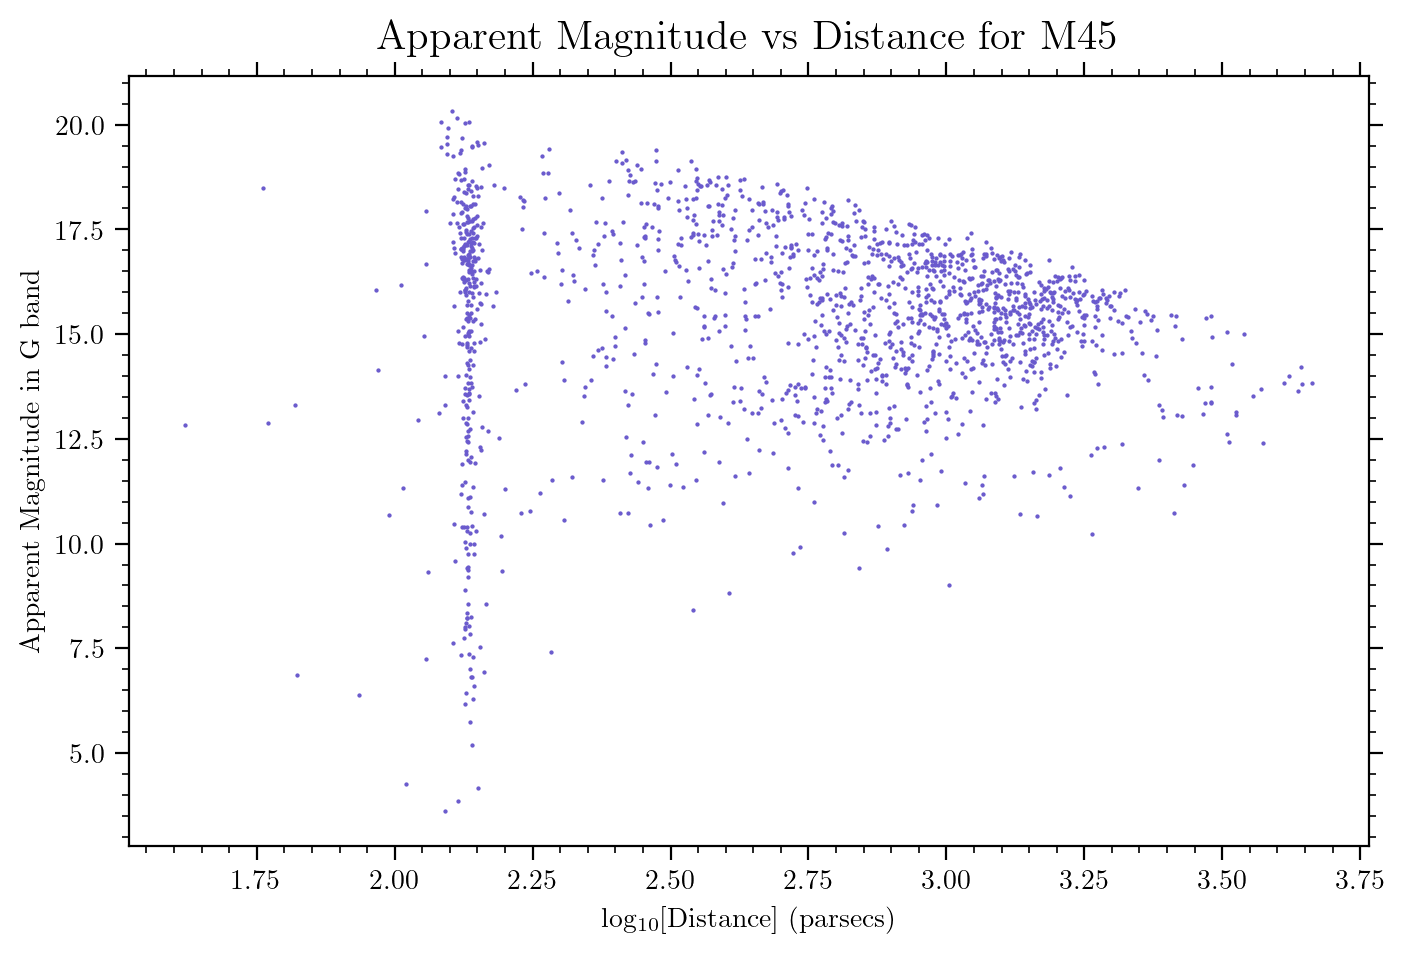

In [130]:
r_m45 = query_gaia('M45')
dist_m45 = plot_appmag_vs_dist('M45', r_m45)

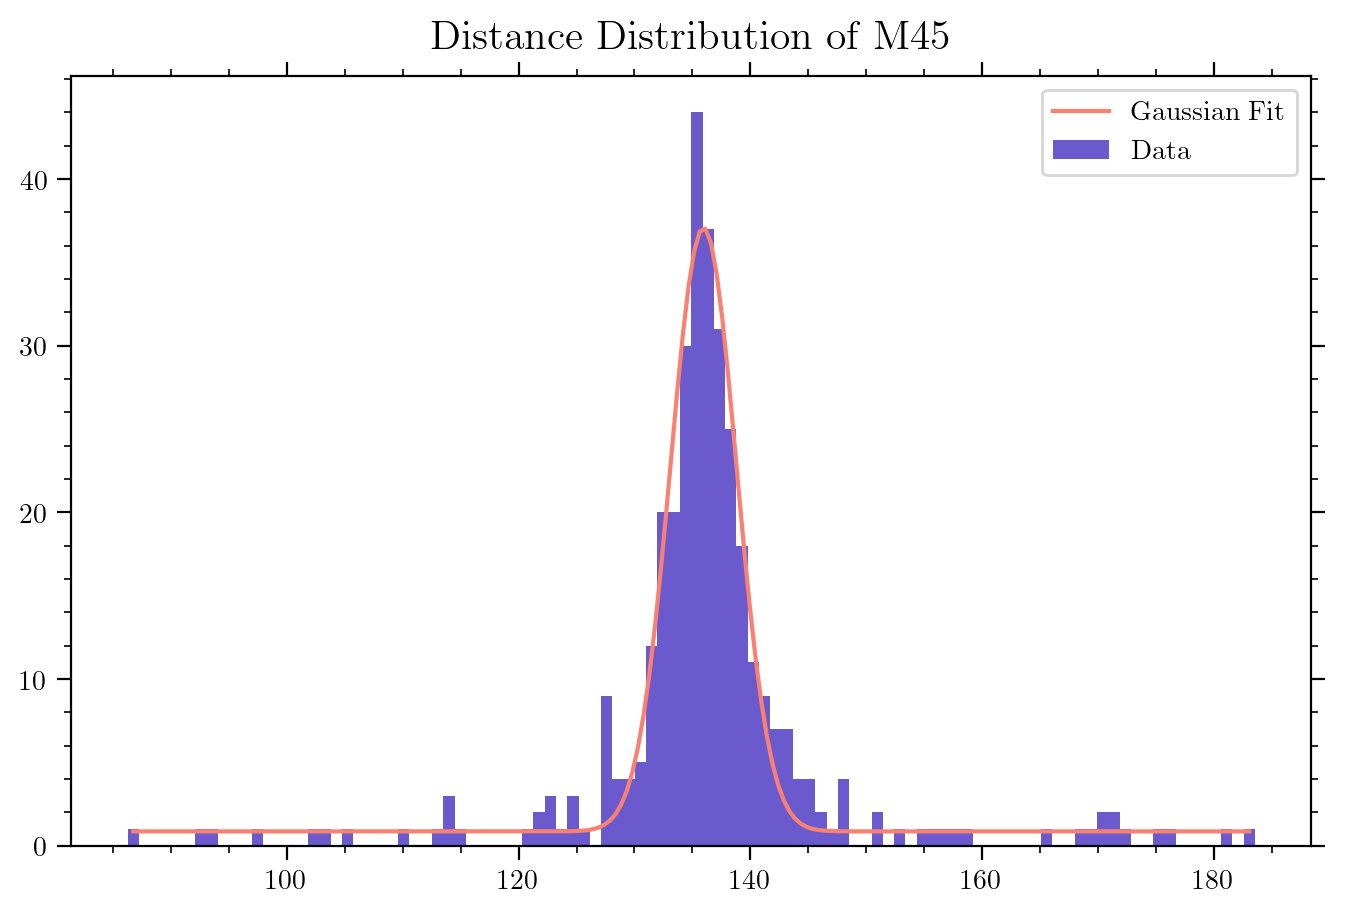

In [131]:
dist_m45 = dist_m45[np.logical_and(dist_m45<185, dist_m45>85)]
popt_m45 = gauss_fit('M45', dist_m45)

INFO: Query finished. [astroquery.utils.tap.core]


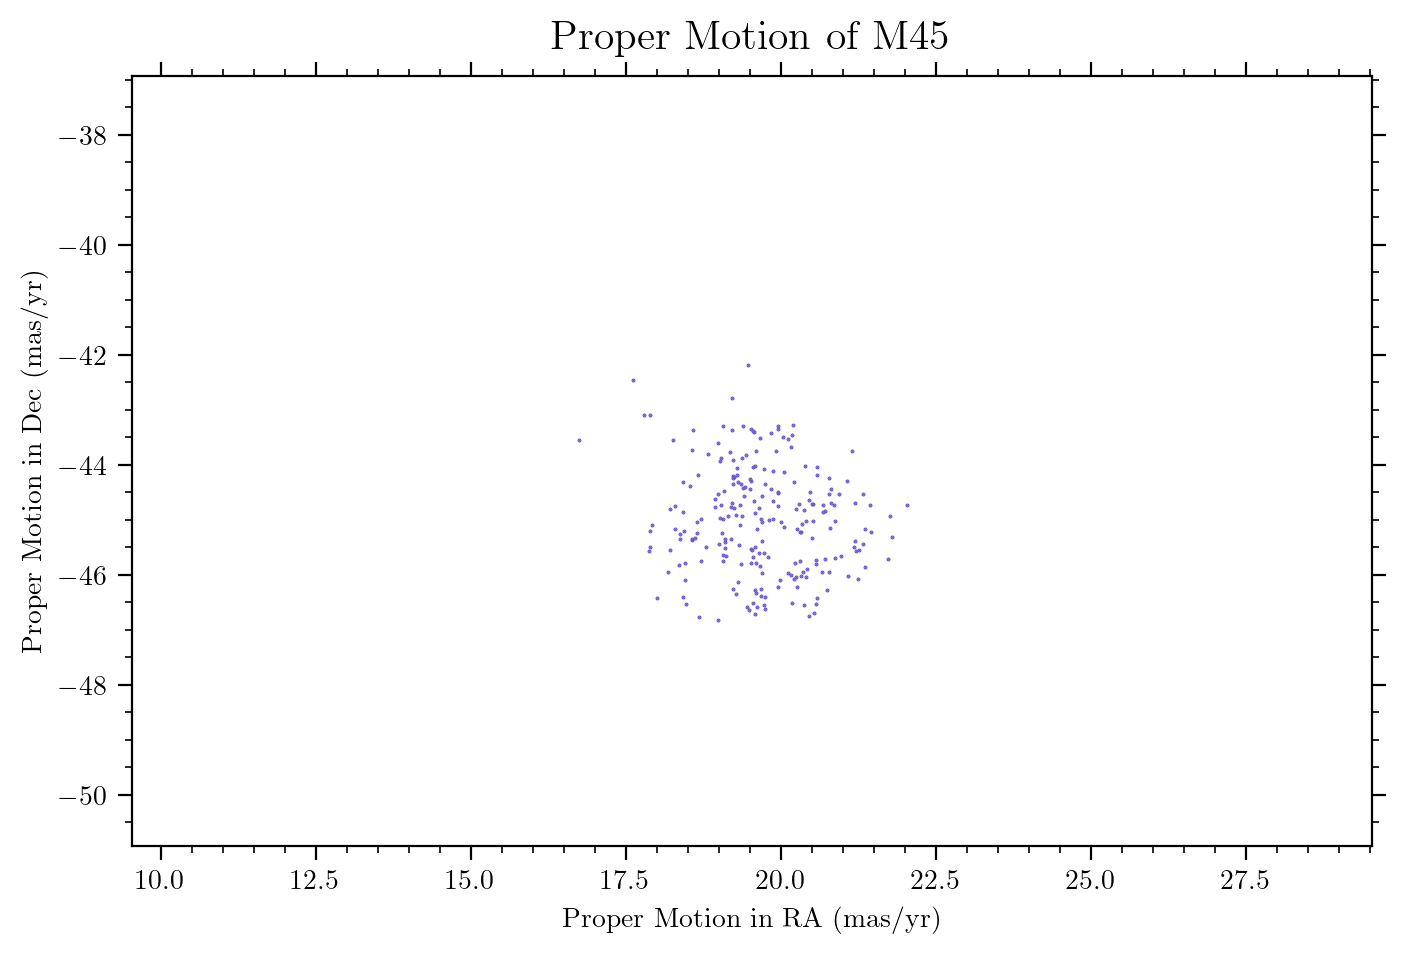

In [132]:
parallax_start_m45, parallax_end_m45 = parallax_cut(dist_m45, popt_m45)
r_m45_2 = plot_pm('M45', parallax_start_m45, parallax_end_m45, 0.25)

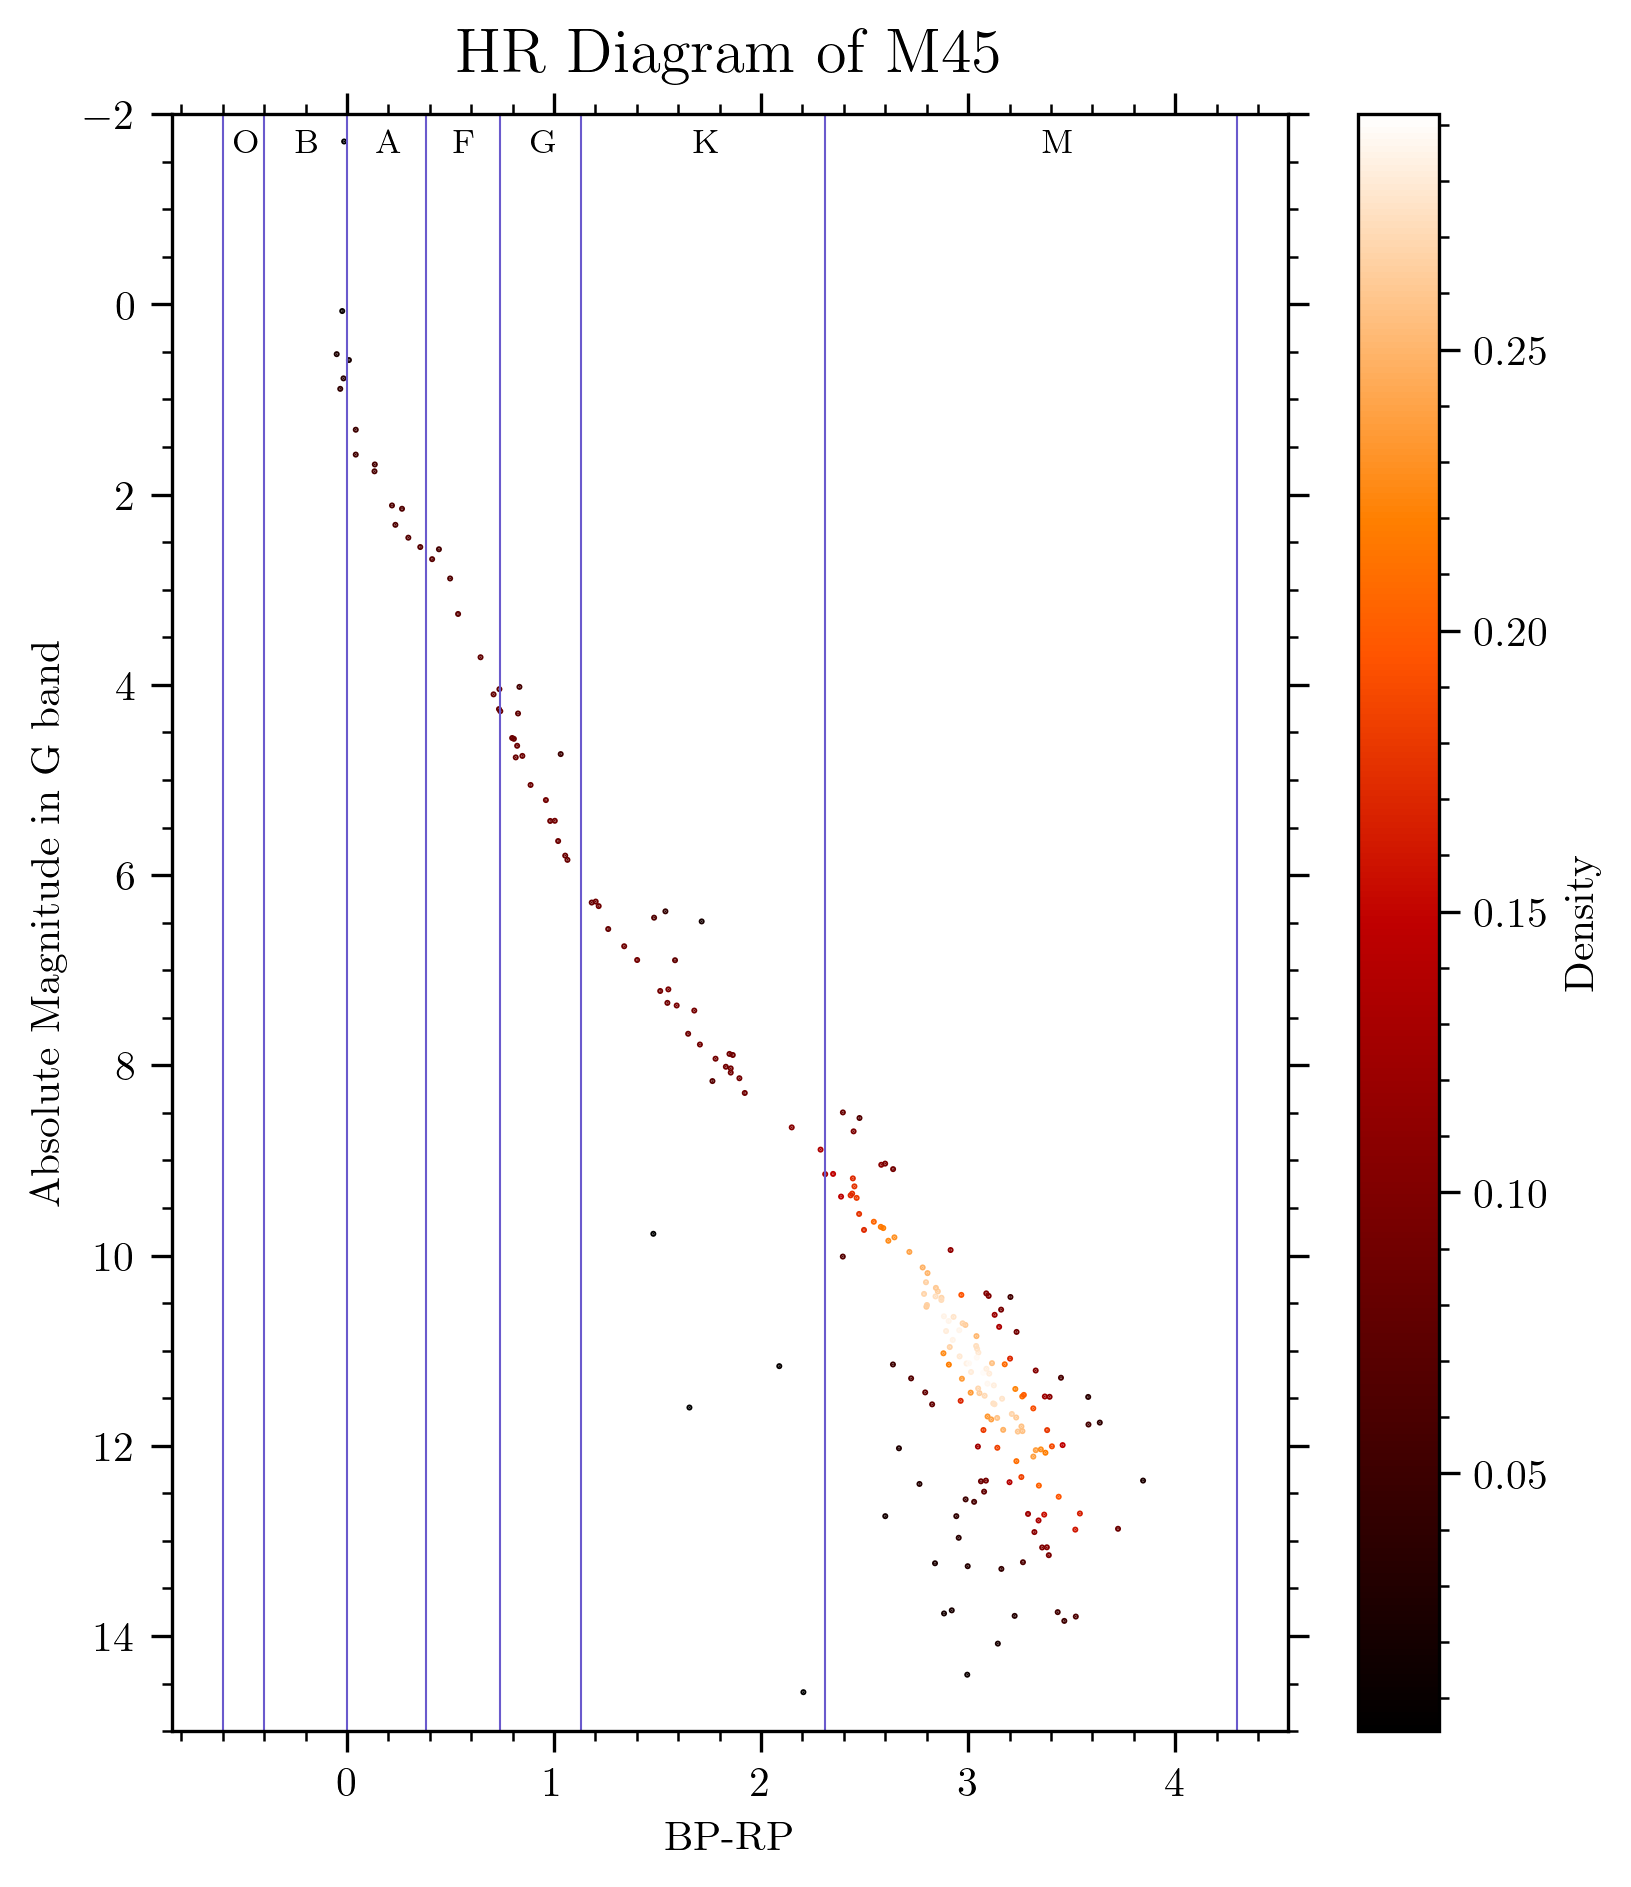

In [254]:
bprp_m45, _ = hr_diag('M45', r_m45_2)

In [257]:
perc_in_spec_class('M45', bprp_m45)

Percentage of O type stars in M45 is 0.0%
Percentage of B type stars in M45 is 2.22%
Percentage of A type stars in M45 is 4.44%
Percentage of F type stars in M45 is 3.56%
Percentage of G type stars in M45 is 7.11%
Percentage of K type stars in M45 is 14.67%
Percentage of M type stars in M45 is 68.0%


# **NGC 188**

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Percentage of O type stars in NGC 188 is 0.0%
Percentage of B type stars in NGC 188 is 0.36%
Percentage of A type stars in NGC 188 is 0.0%
Percentage of F type stars in NGC 188 is 2.54%
Percentage of G type stars in NGC 188 is 81.16%
Percentage of K type stars in NGC 188 is 15.94%
Percentage of M type stars in NGC 188 is 0.0%


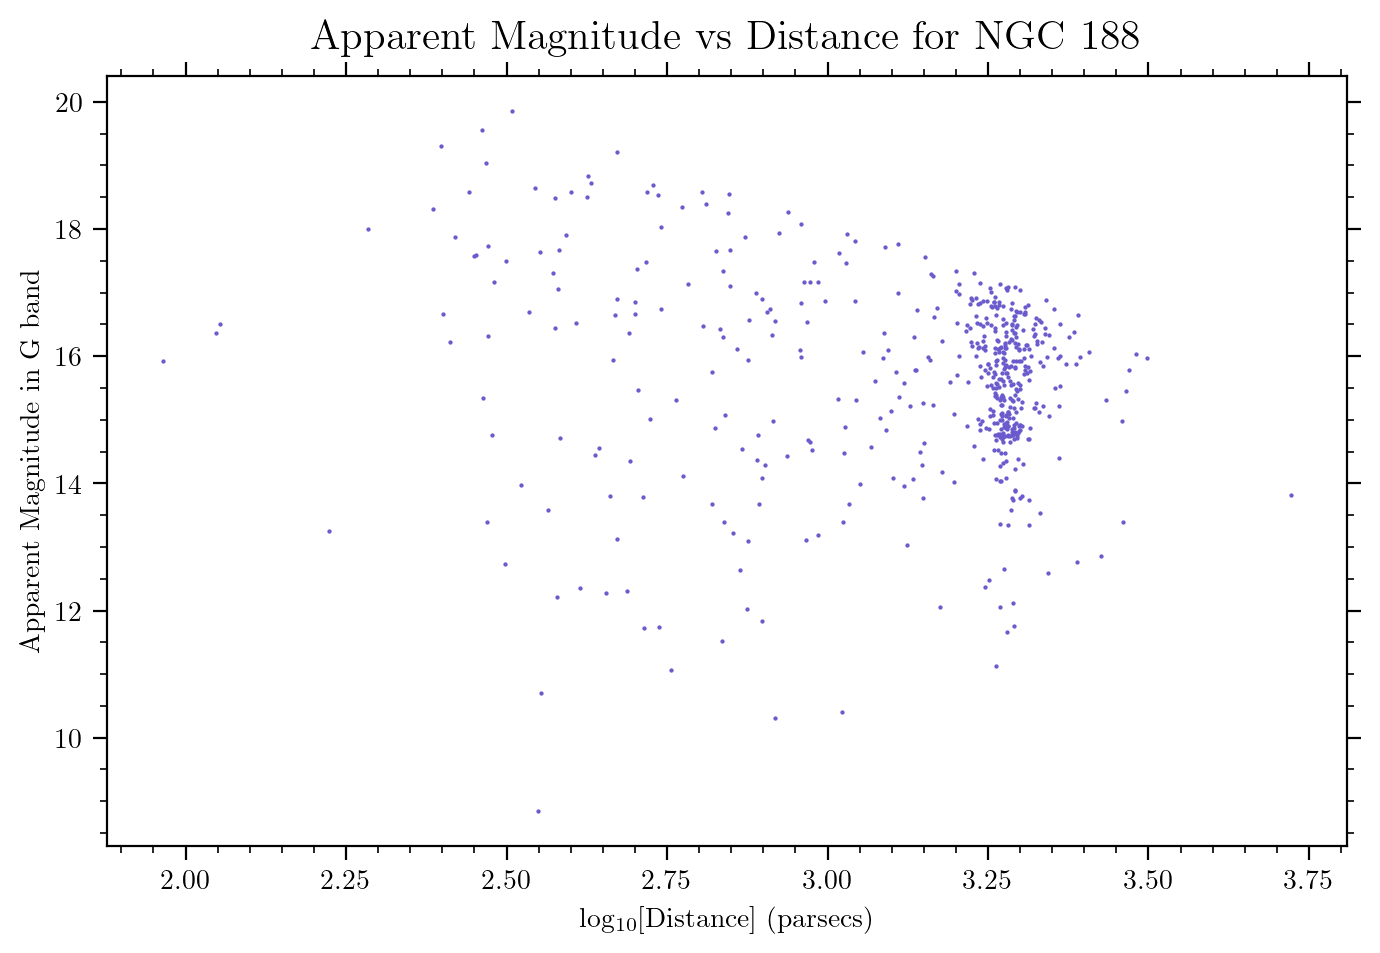

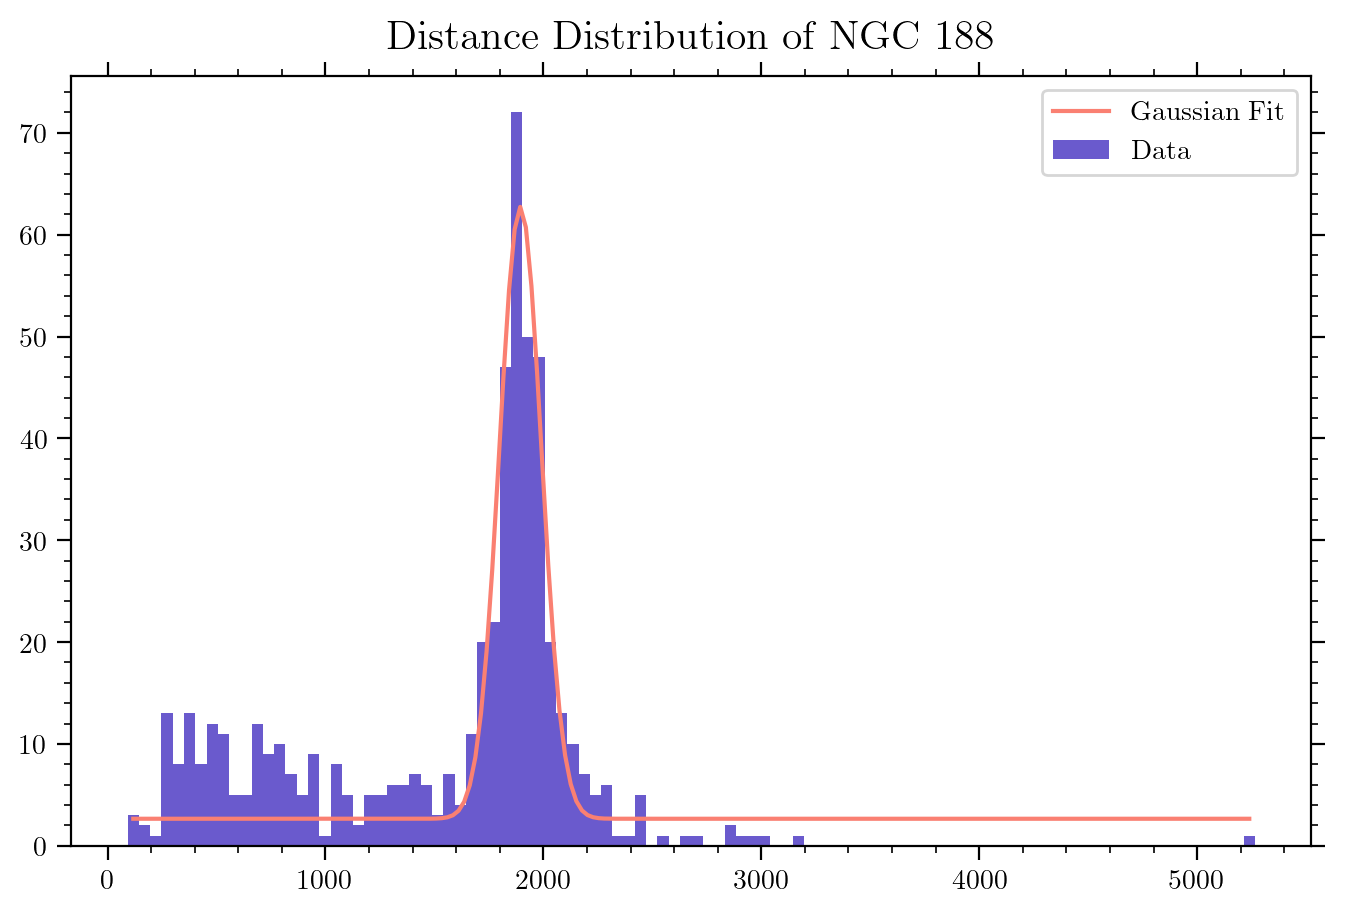

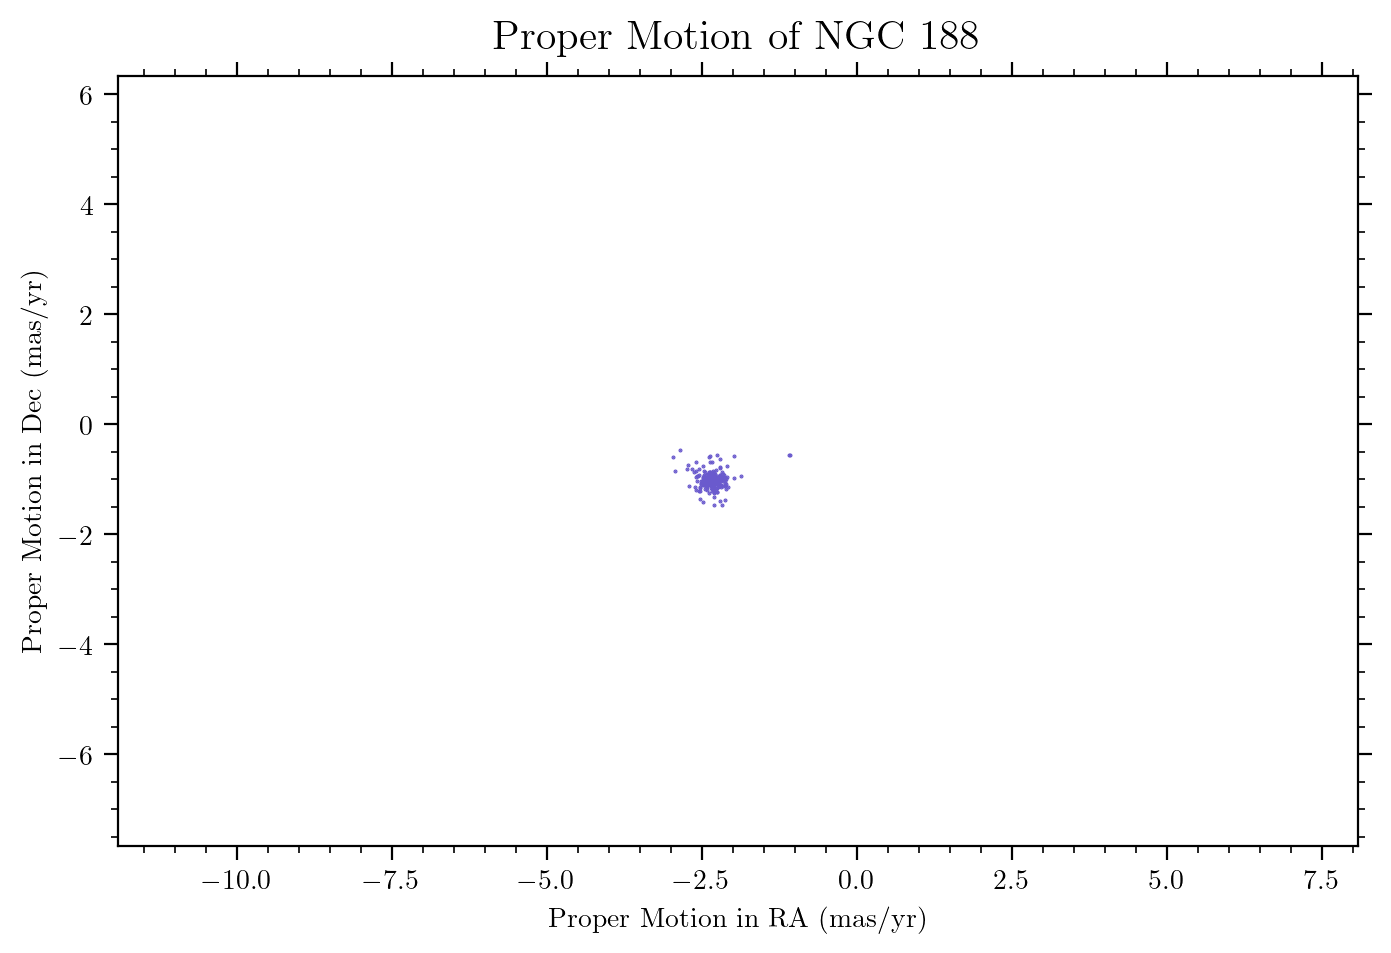

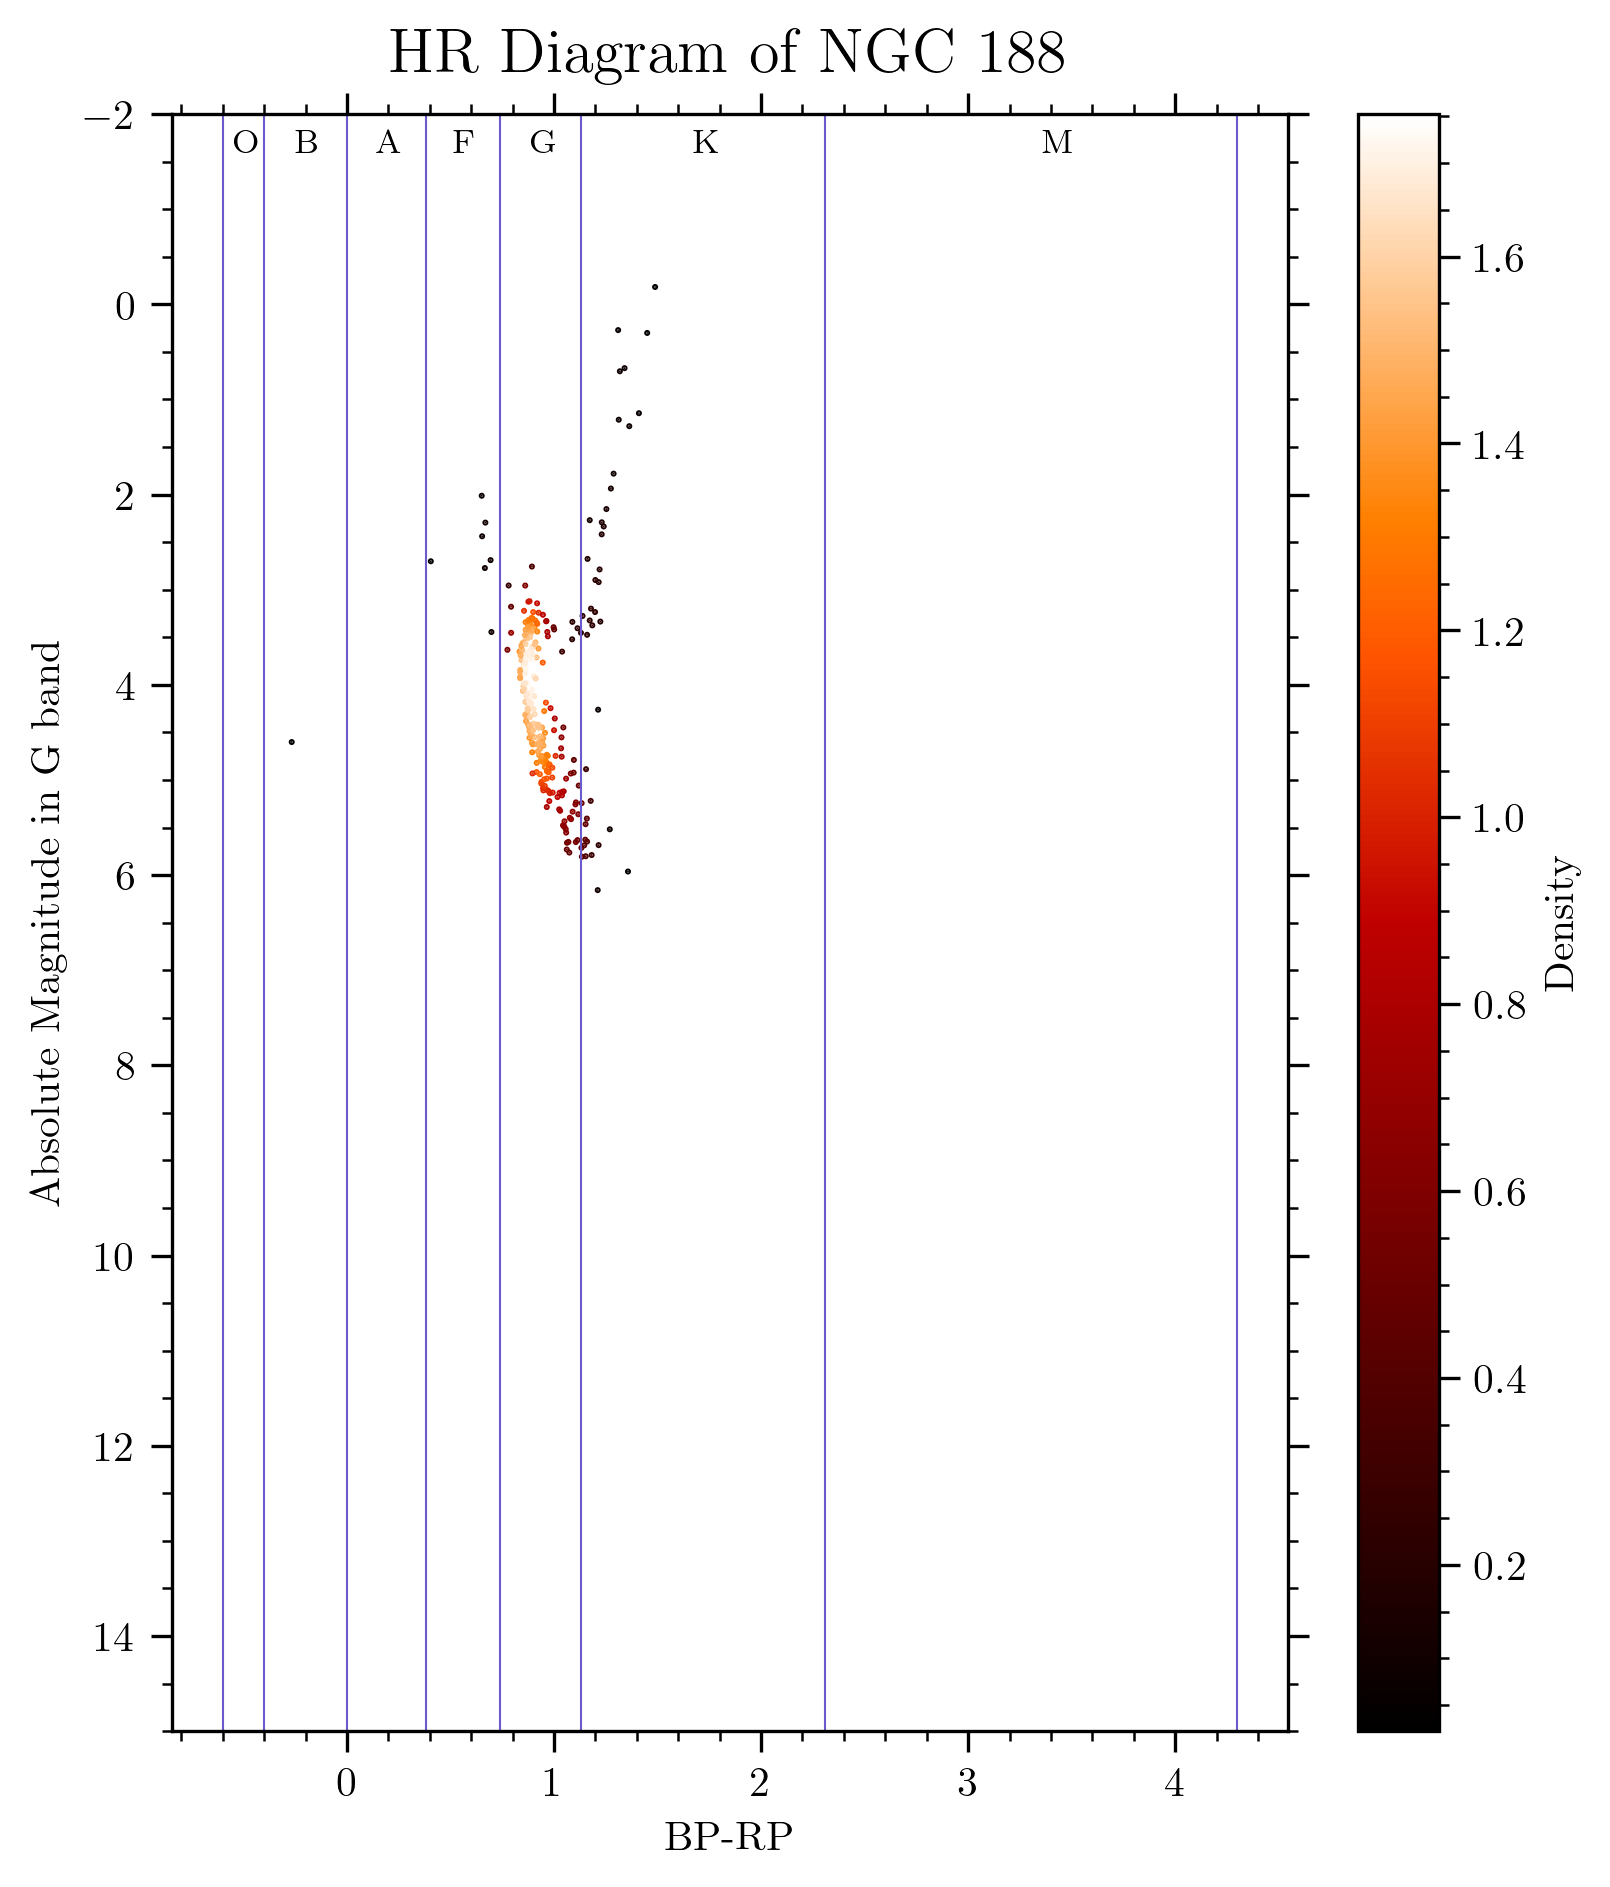

In [260]:
plot_all('NGC 188')

# **Messier 50**

INFO: Query finished. [astroquery.utils.tap.core]


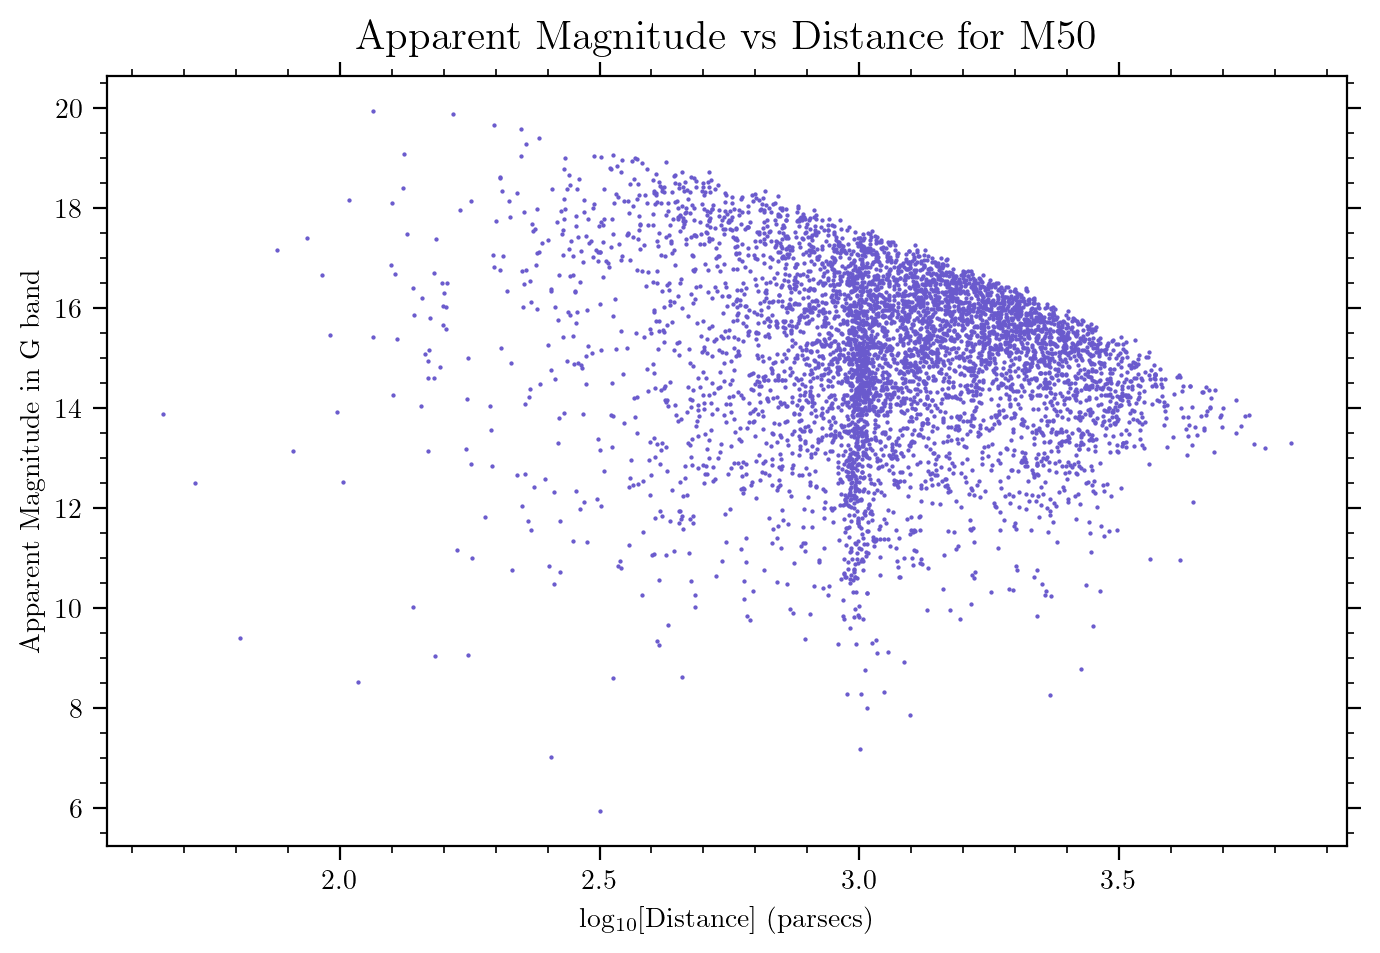

In [135]:
r_m50 = query_gaia('M50')
dist_m50 = plot_appmag_vs_dist('M50', r_m50)

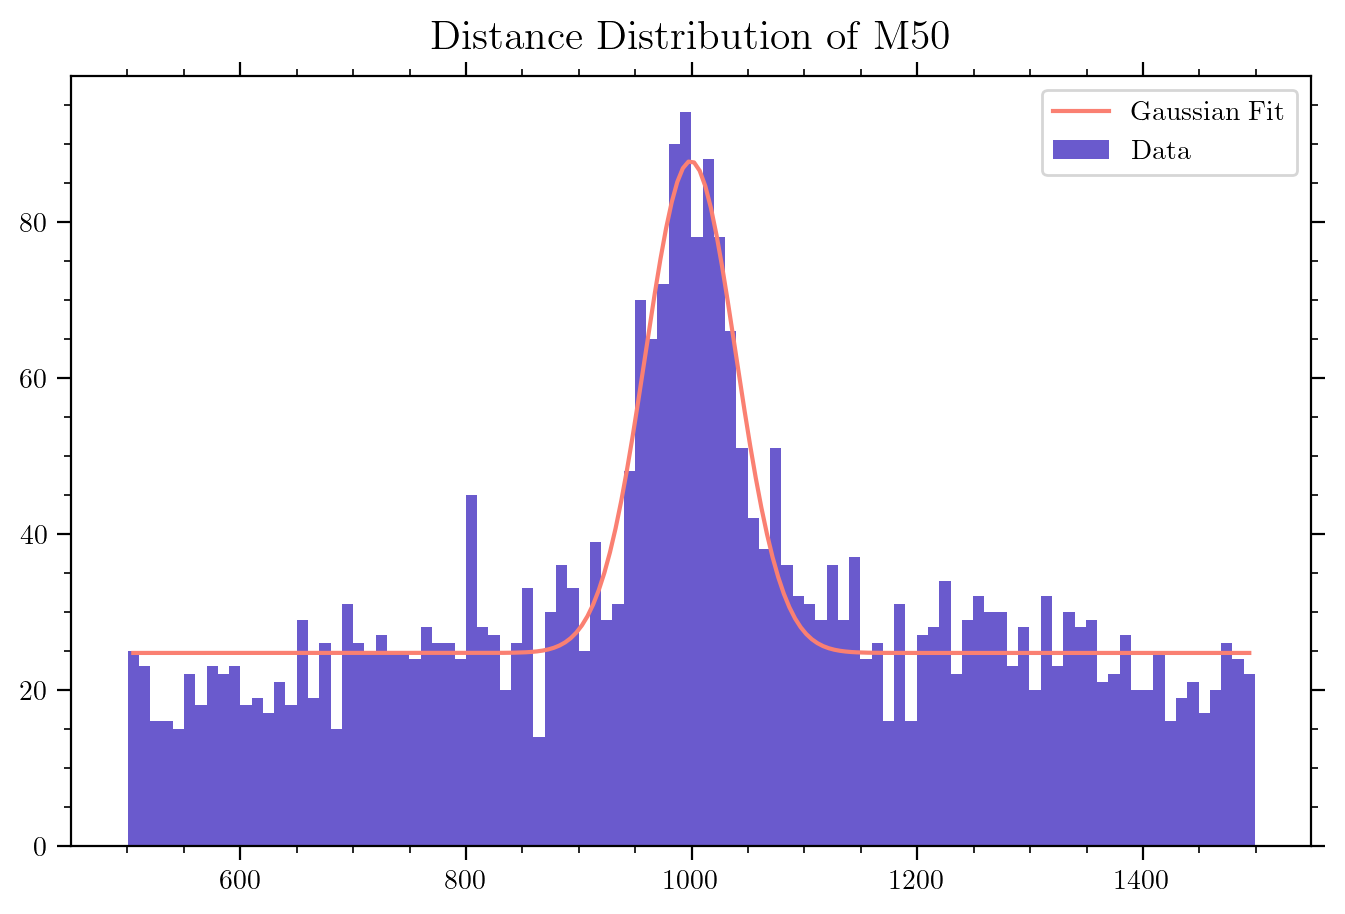

In [136]:
dist_m50 = dist_m50[np.logical_and(dist_m50<1500, dist_m50>500)]
popt_m50 = gauss_fit('M50', dist_m50)

INFO: Query finished. [astroquery.utils.tap.core]


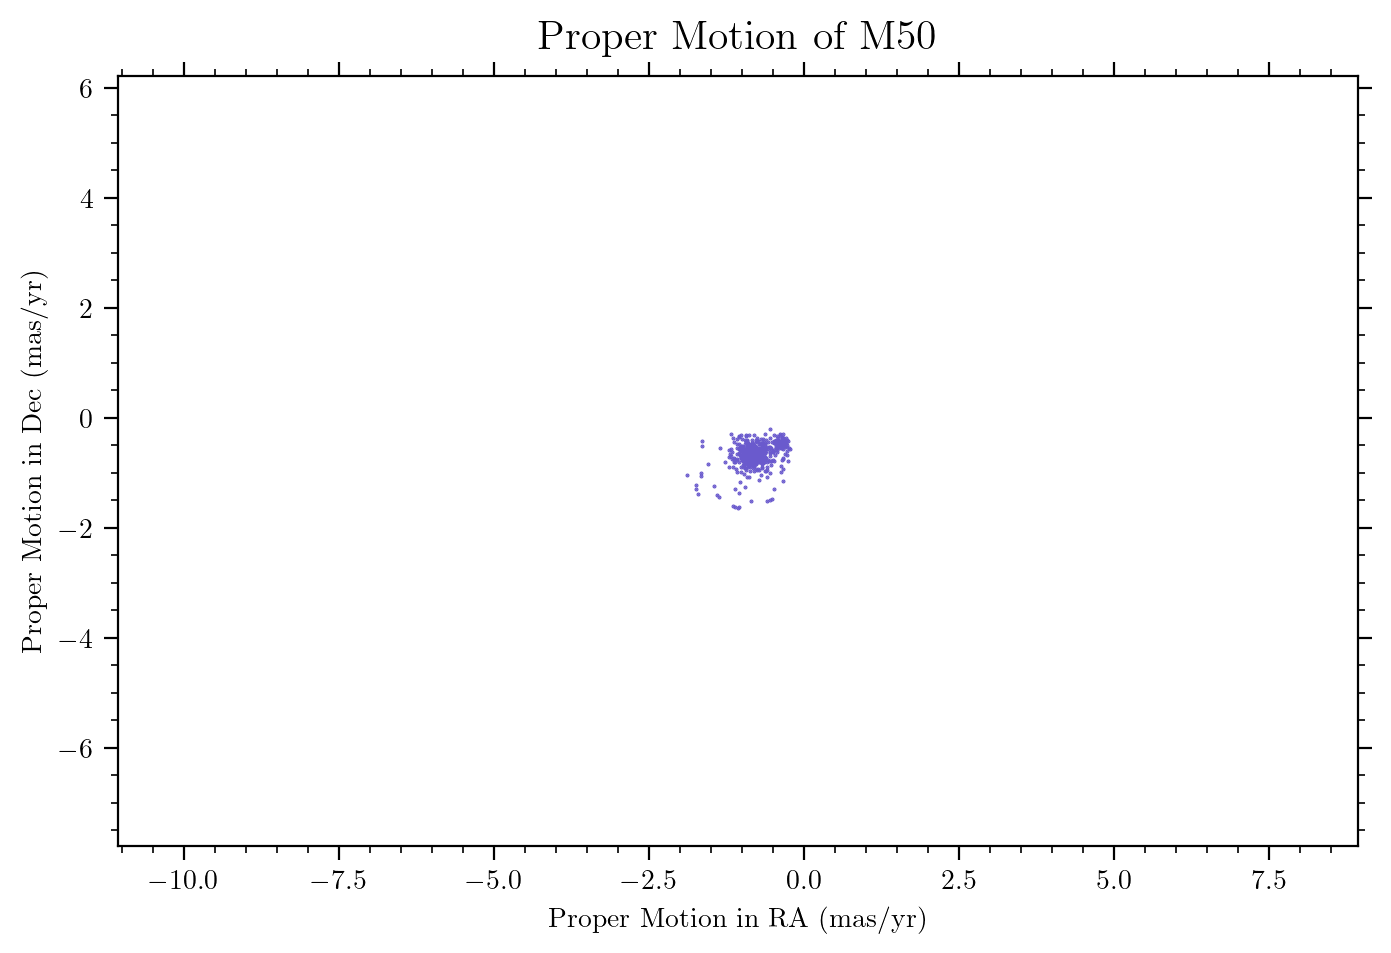

In [137]:
parallax_start_m50, parallax_end_m50 = parallax_cut(dist_m50, popt_m50)
r_m50_2 = plot_pm('M50', parallax_start_m50, parallax_end_m50, 0.2)

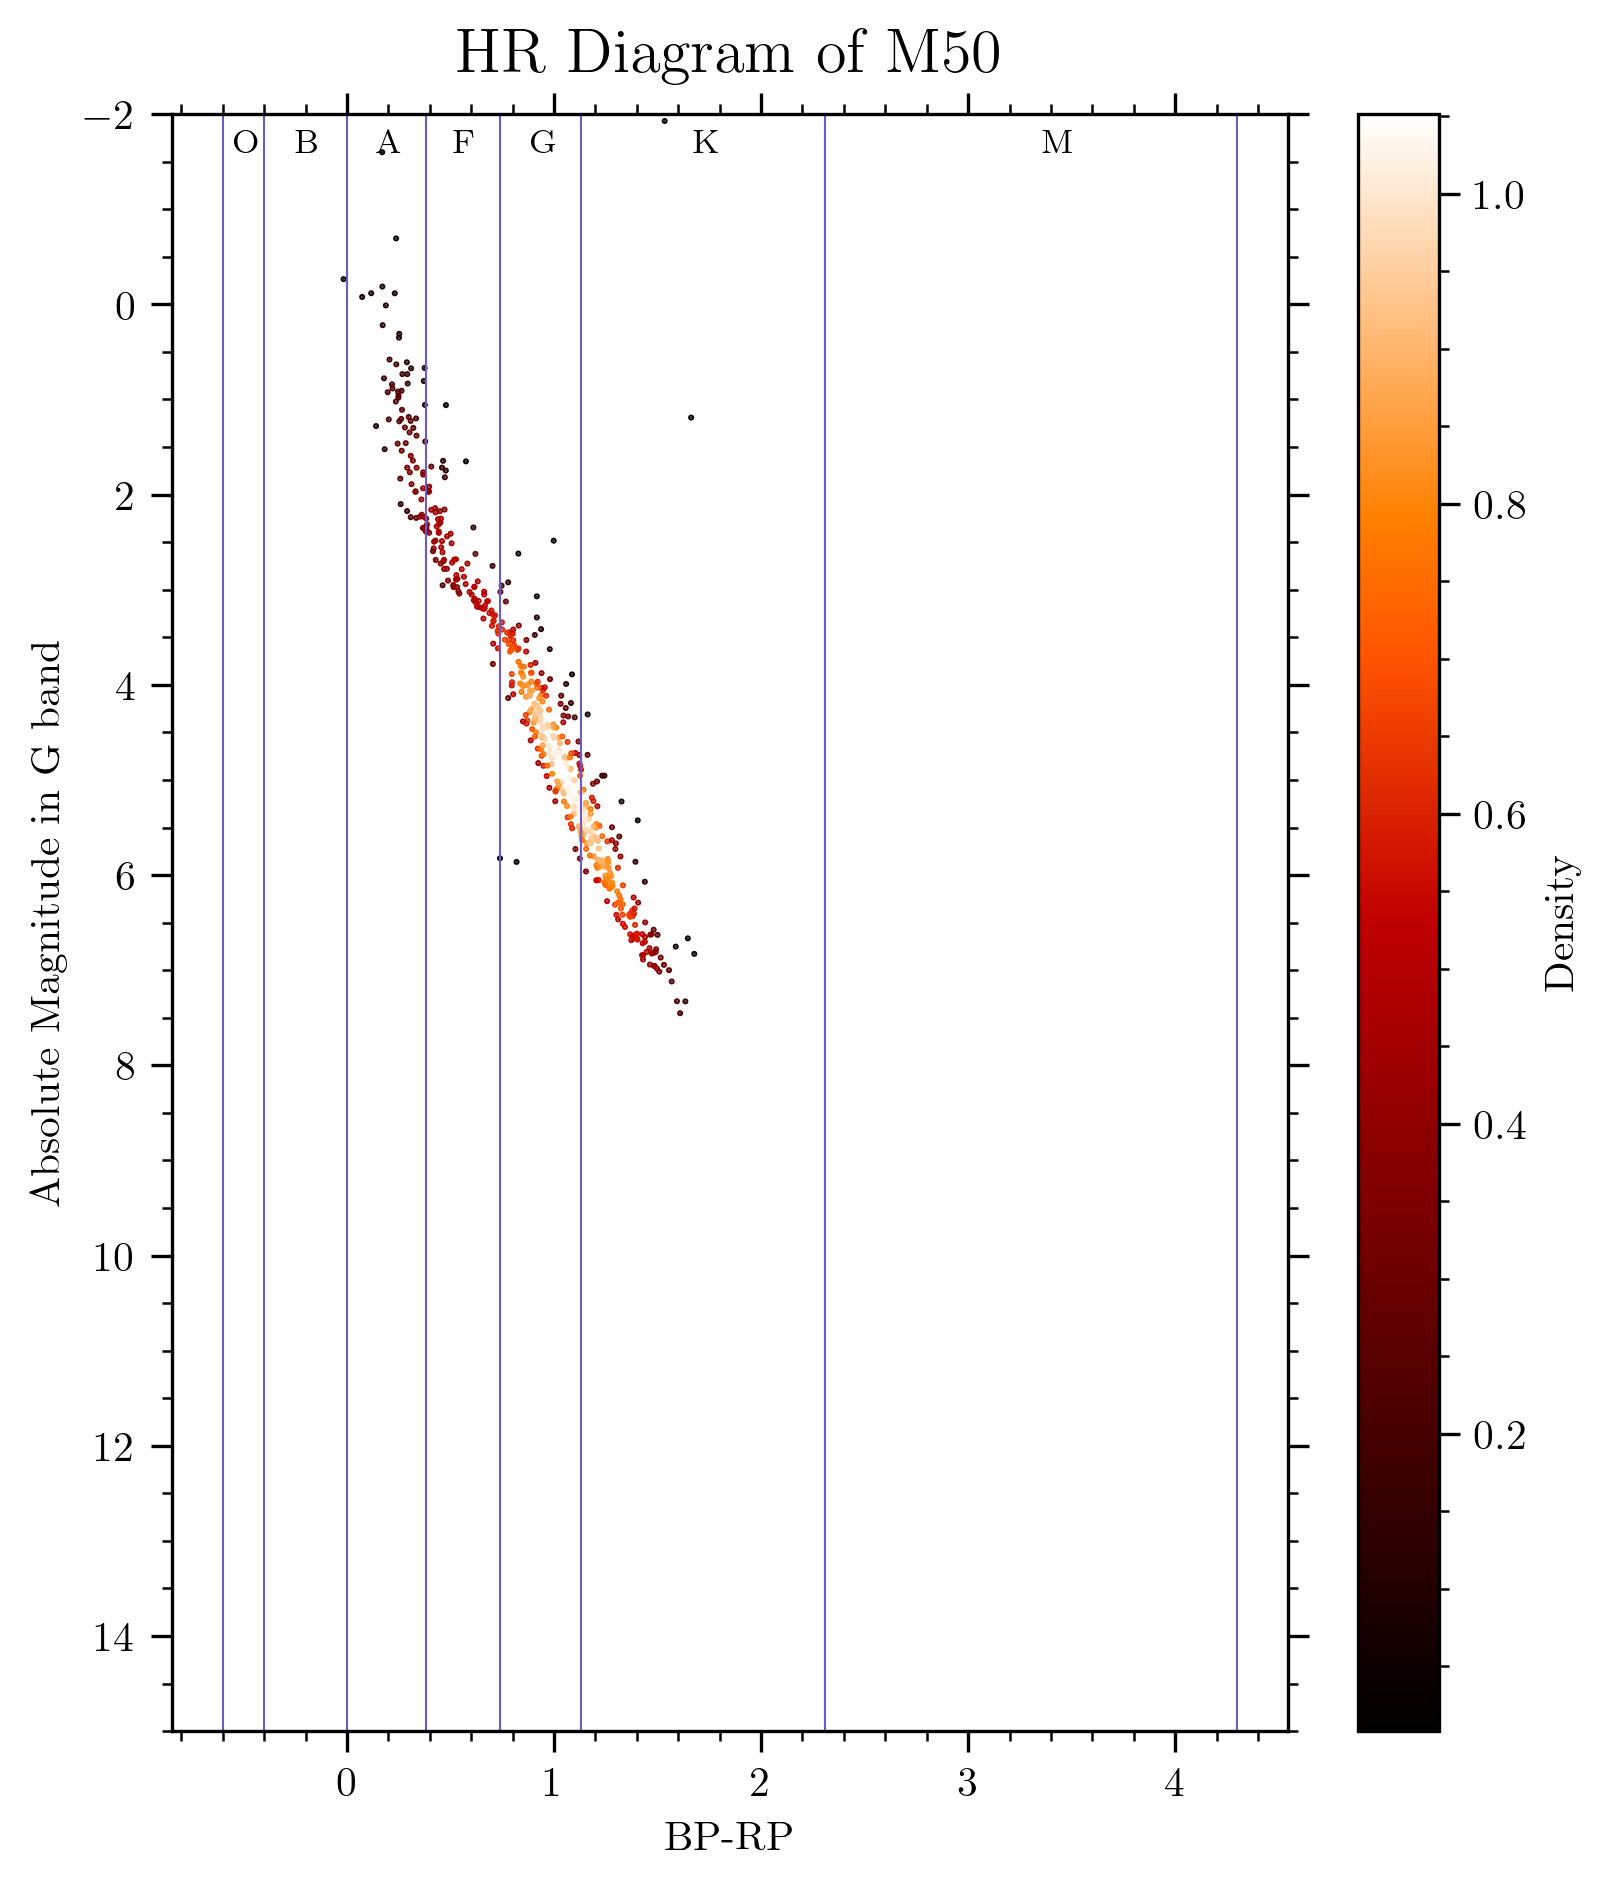

In [261]:
bprp_m50, _ = hr_diag('M50', r_m50_2)

In [262]:
perc_in_spec_class('M50', bprp_m50)

Percentage of O type stars in M50 is 0.0%
Percentage of B type stars in M50 is 0.18%
Percentage of A type stars in M50 is 12.41%
Percentage of F type stars in M50 is 18.07%
Percentage of G type stars in M50 is 39.78%
Percentage of K type stars in M50 is 29.56%
Percentage of M type stars in M50 is 0.0%


# **Messier 67**

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


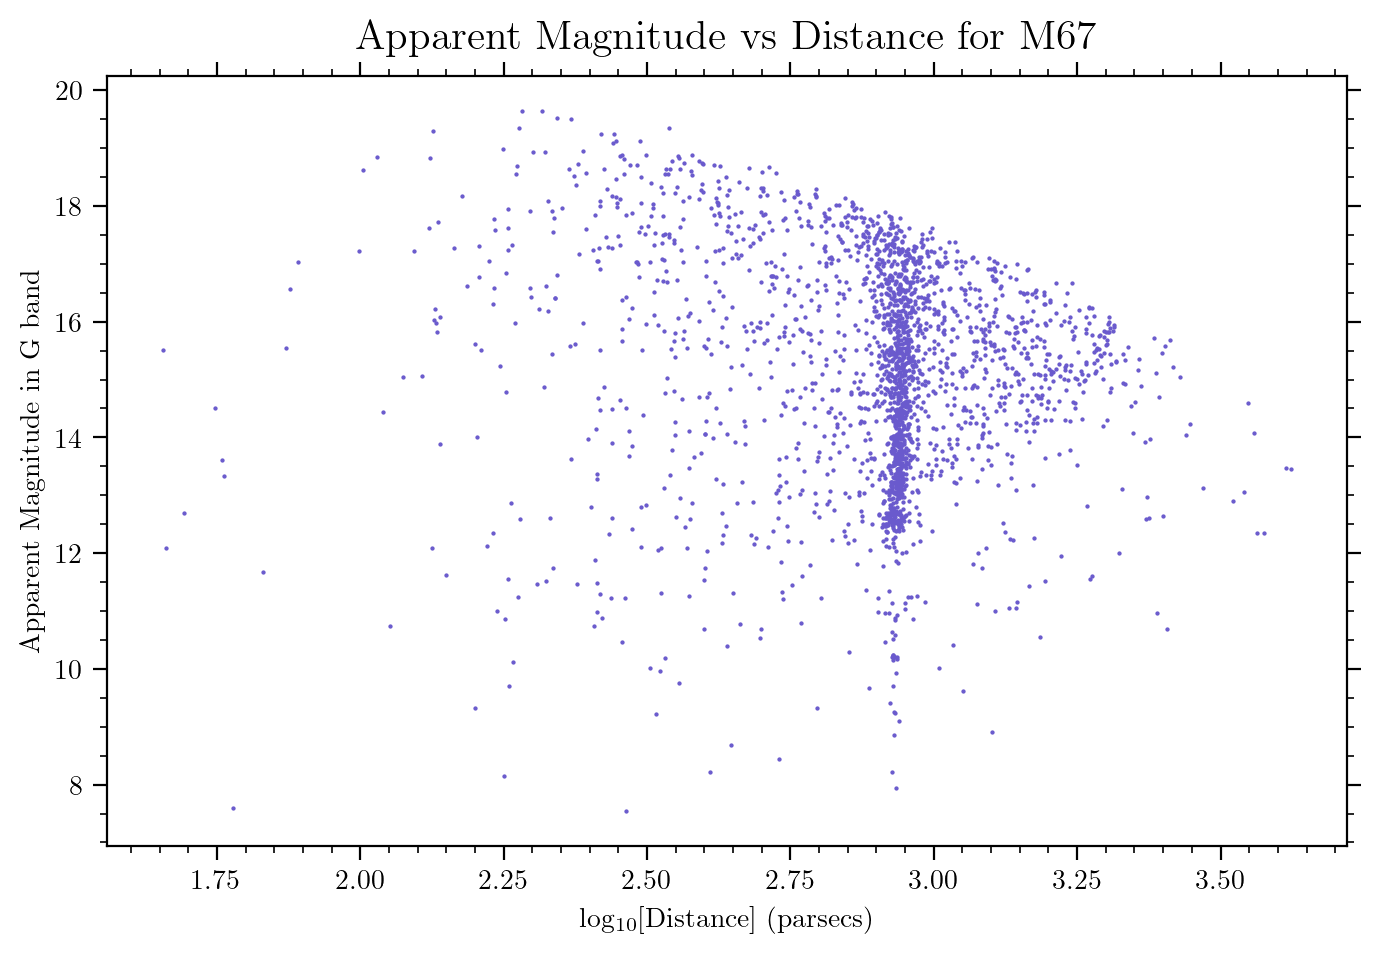

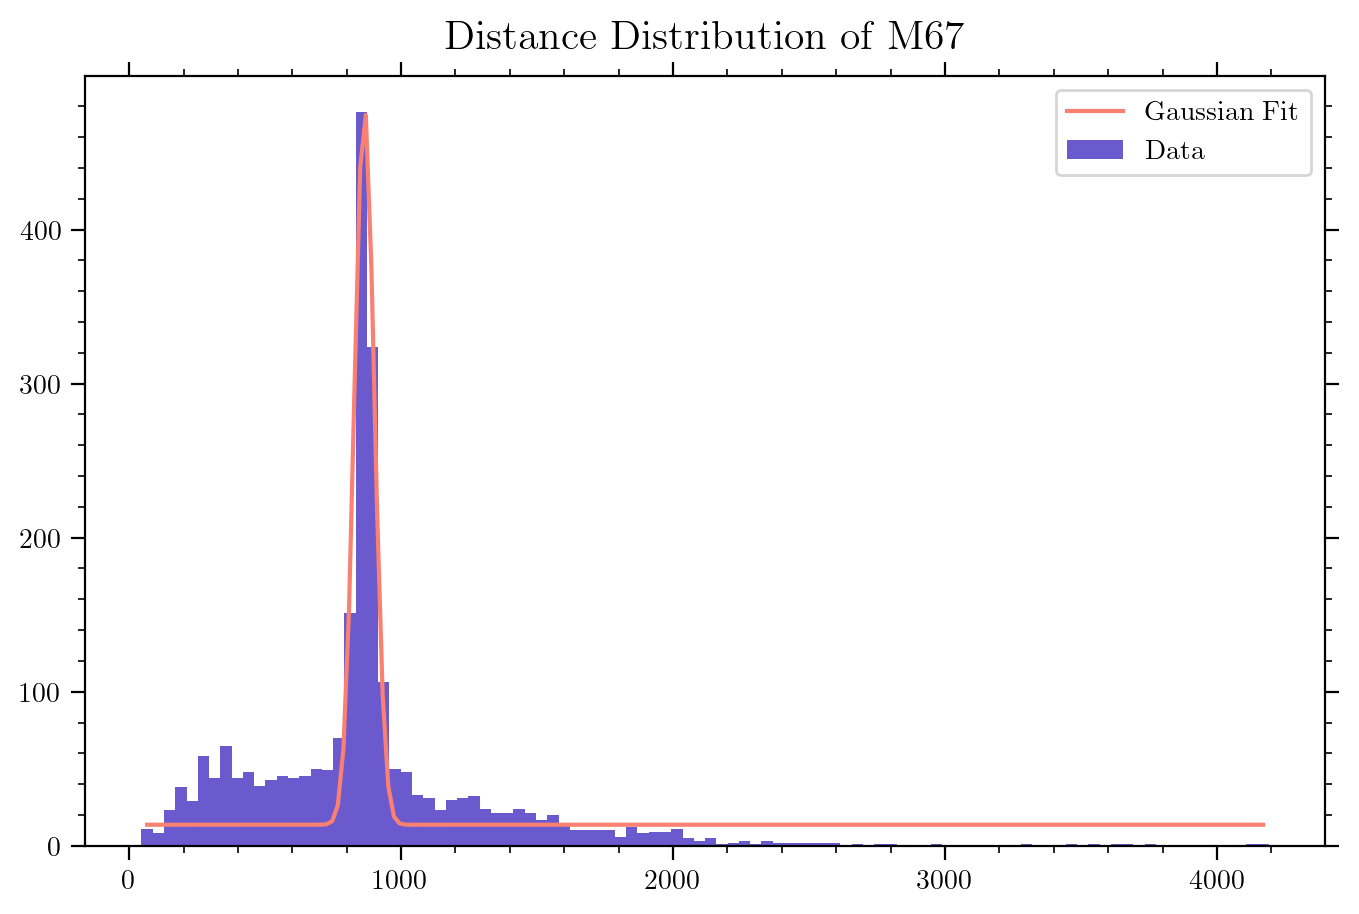

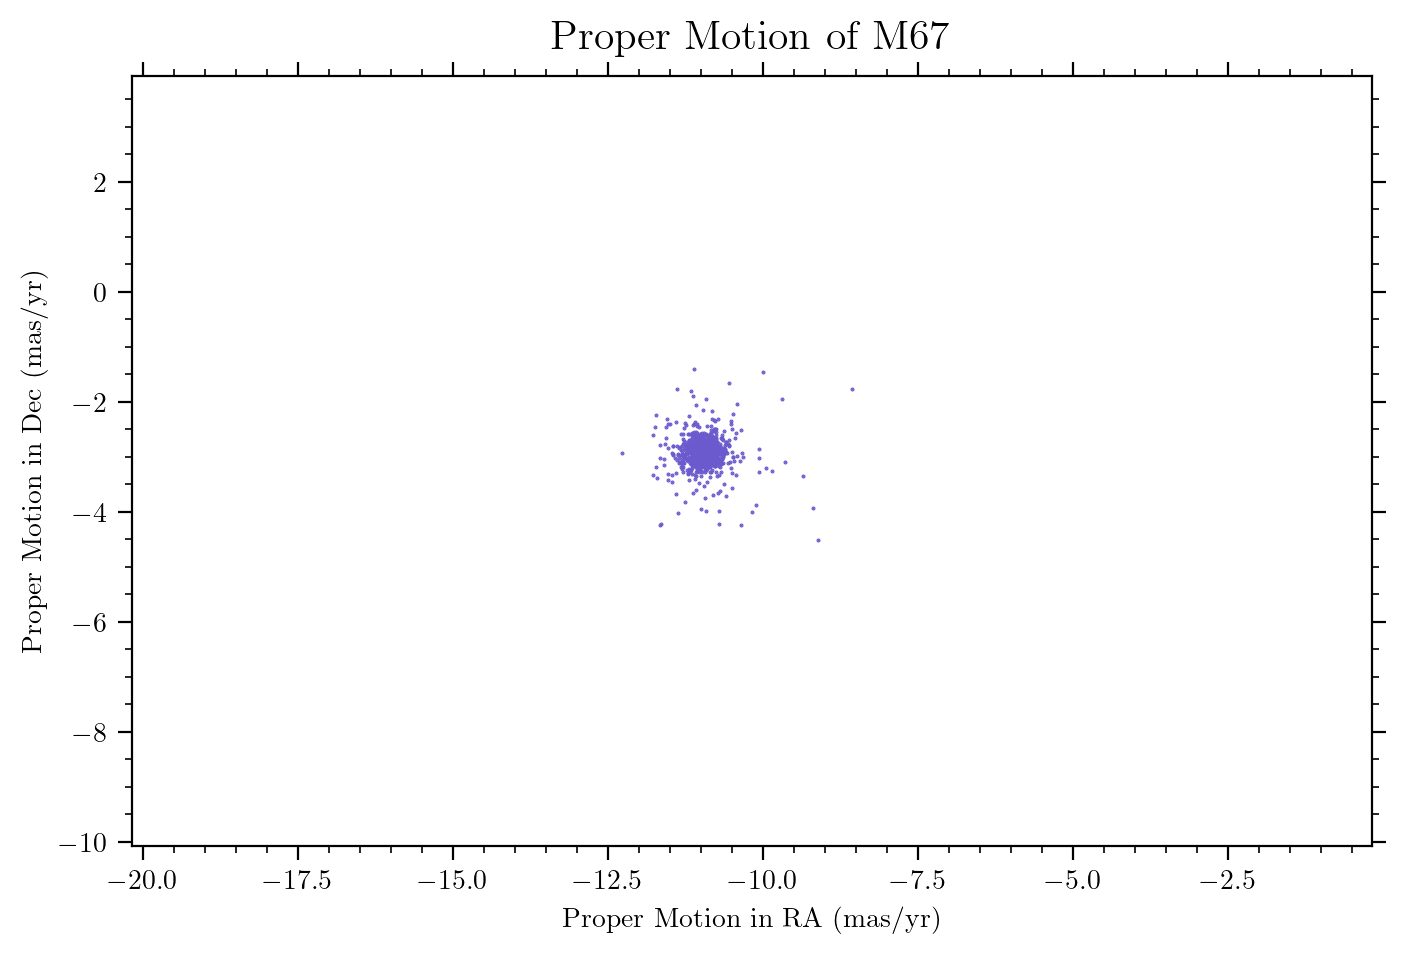

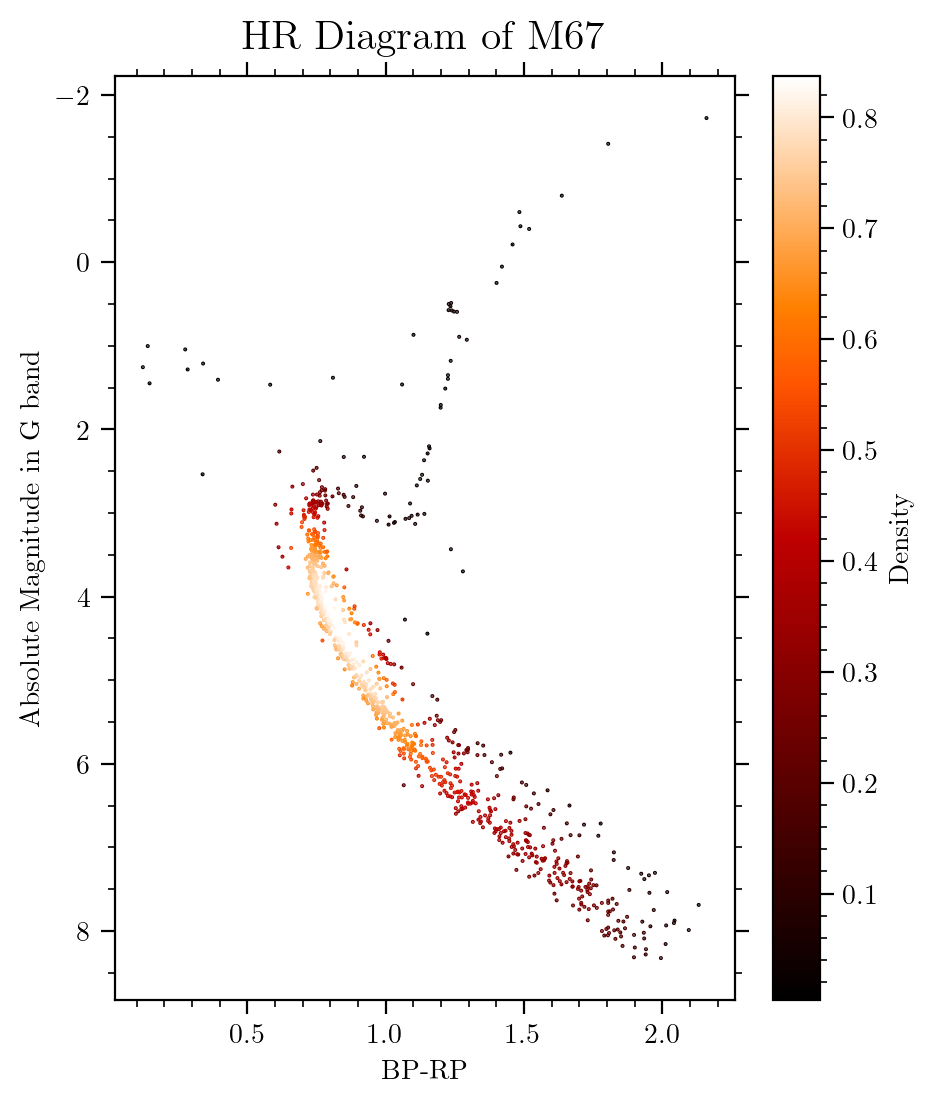

In [138]:
plot_all('M67')

# **Messier 6**

INFO: Query finished. [astroquery.utils.tap.core]


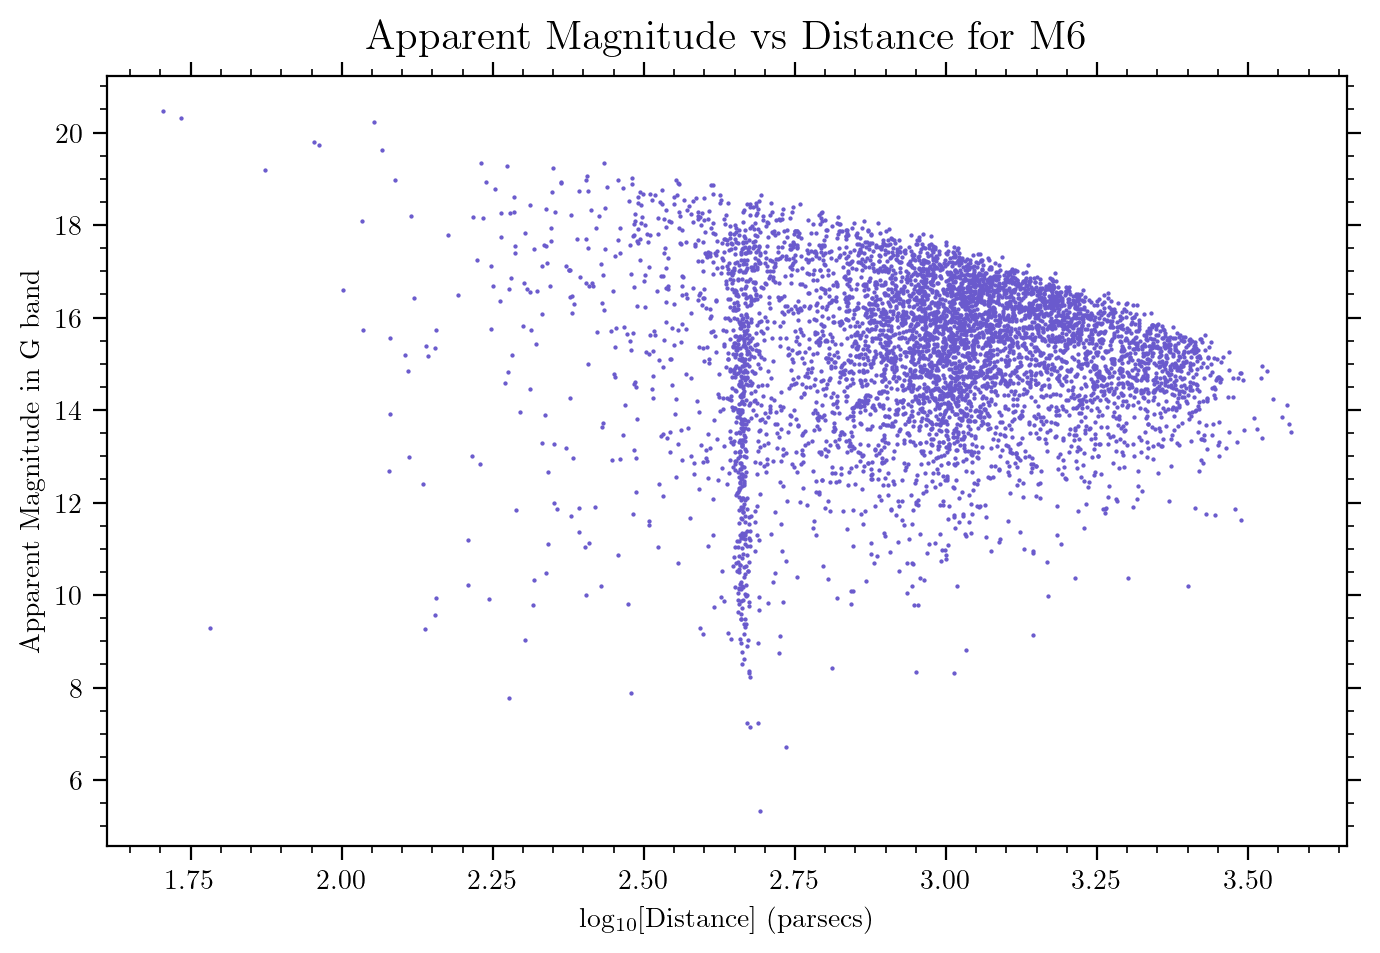

In [139]:
r_m6 = query_gaia('M6')
dist_m6 = plot_appmag_vs_dist('M6', r_m6)

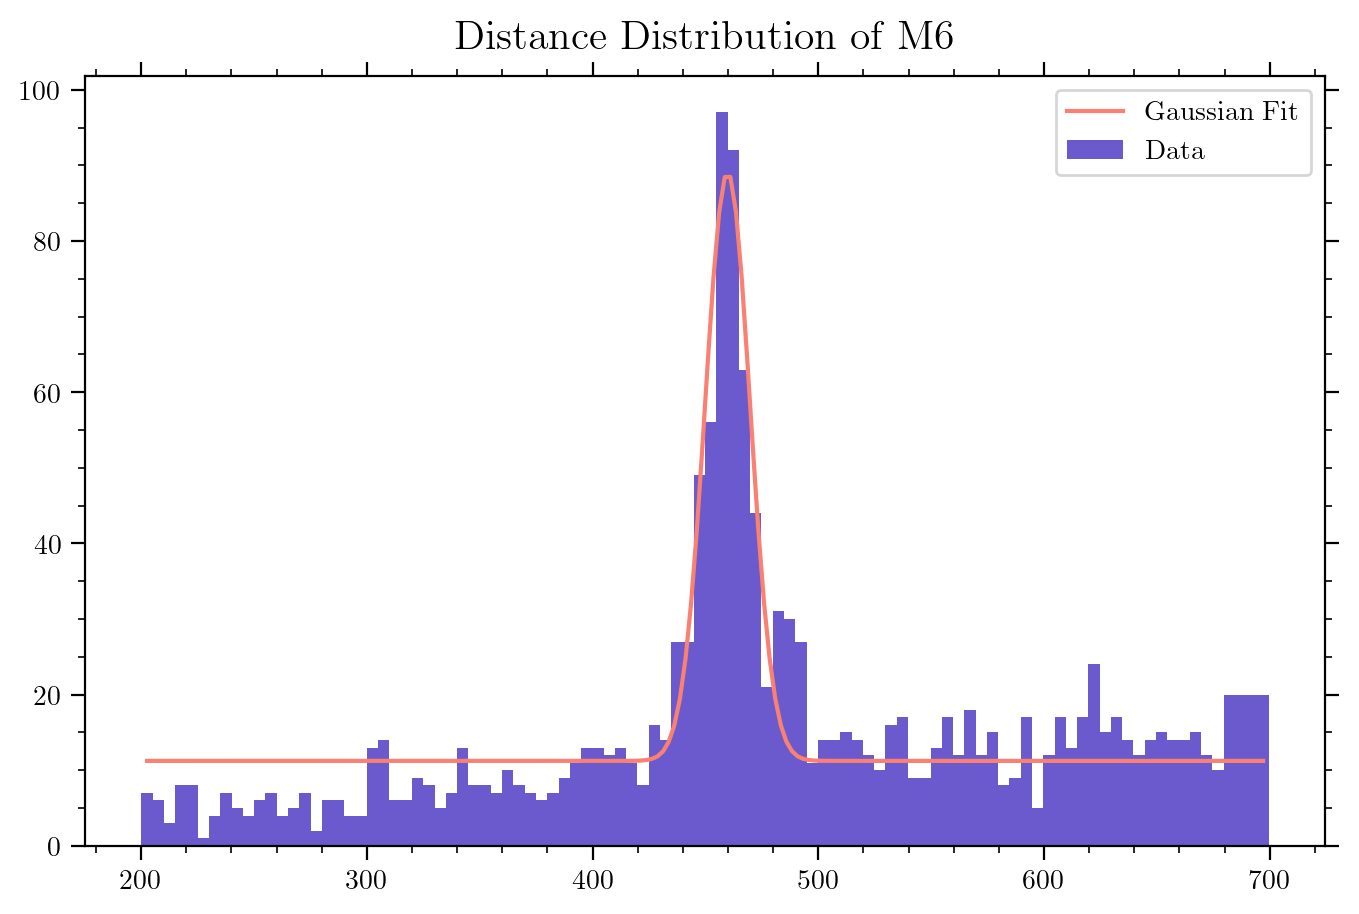

In [140]:
dist_m6 = dist_m6[np.logical_and(dist_m6<700, dist_m6>200)]
popt_m6 = gauss_fit('M6', dist_m6)

INFO: Query finished. [astroquery.utils.tap.core]


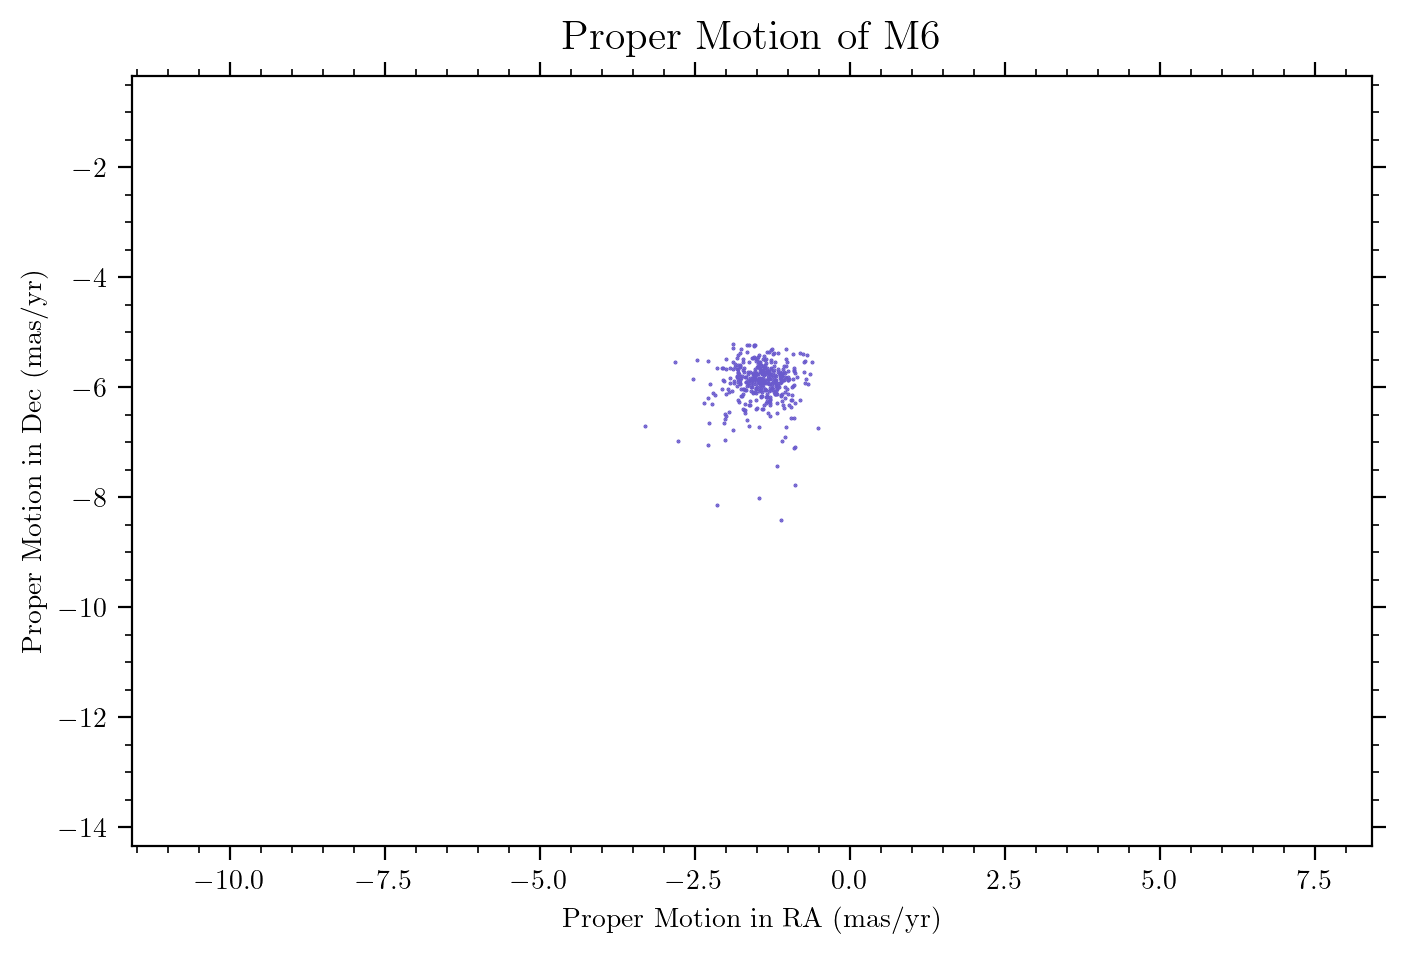

In [141]:
parallax_start_m6, parallax_end_m6 = parallax_cut(dist_m6, popt_m6)
r_m6_2 = plot_pm('M6', parallax_start_m6, parallax_end_m6, 0.3)

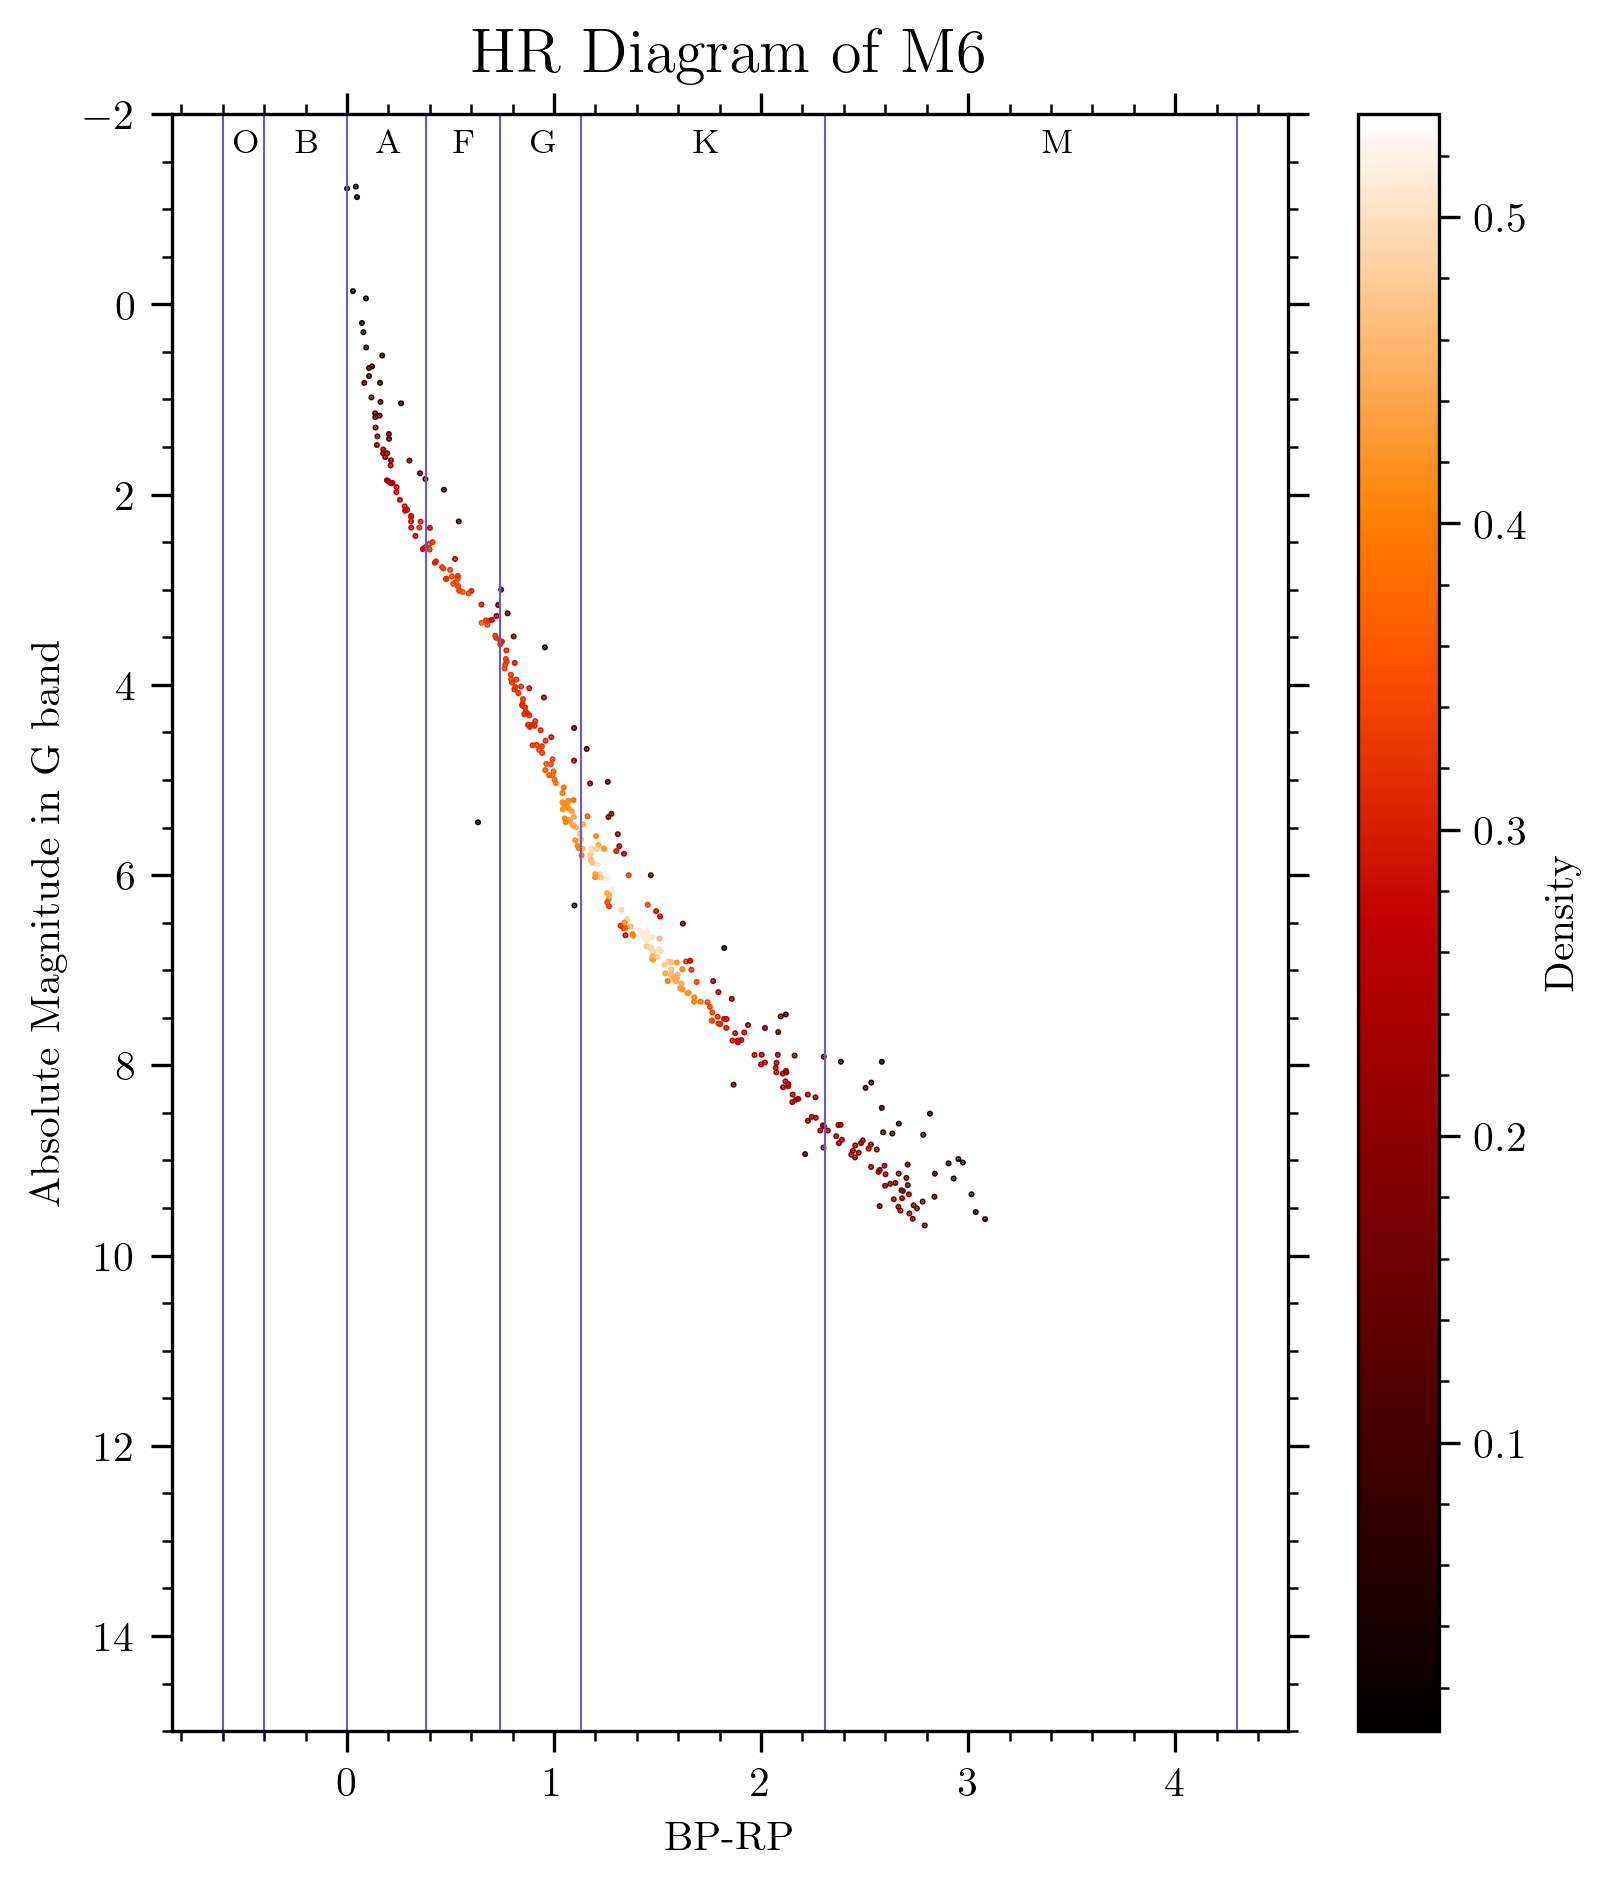

In [263]:
bprp_m6, _ = hr_diag('M6', r_m6_2)

In [264]:
perc_in_spec_class('M6', bprp_m6)

Percentage of O type stars in M6 is 0.0%
Percentage of B type stars in M6 is 0.0%
Percentage of A type stars in M6 is 13.4%
Percentage of F type stars in M6 is 9.18%
Percentage of G type stars in M6 is 19.85%
Percentage of K type stars in M6 is 42.43%
Percentage of M type stars in M6 is 15.14%


# **Messier 7**

INFO: Query finished. [astroquery.utils.tap.core]


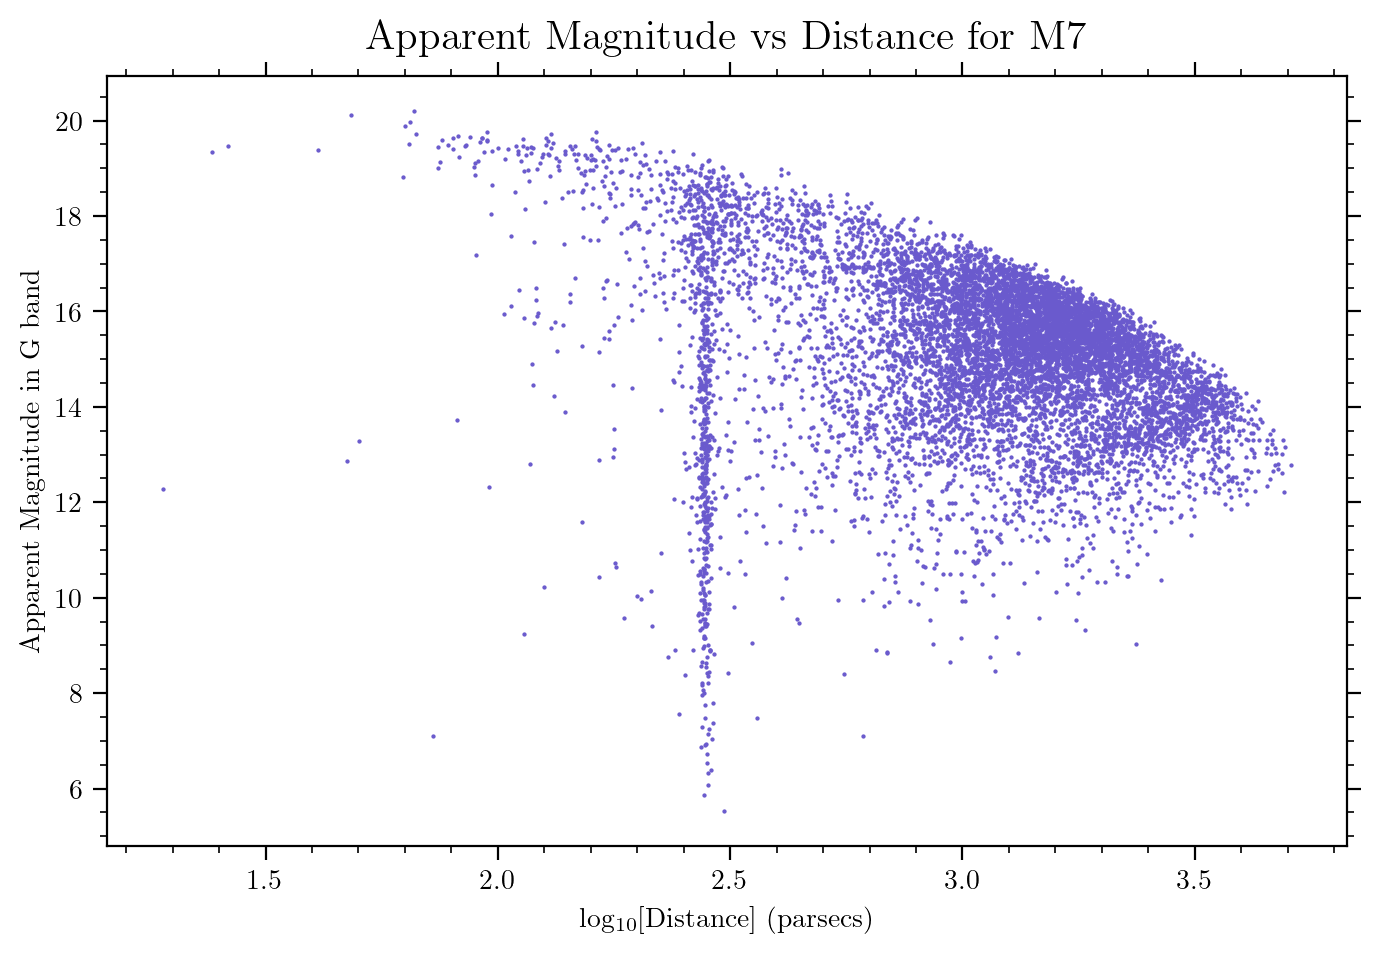

In [143]:
r_m7 = query_gaia('M7')
dist_m7 = plot_appmag_vs_dist('M7', r_m7)

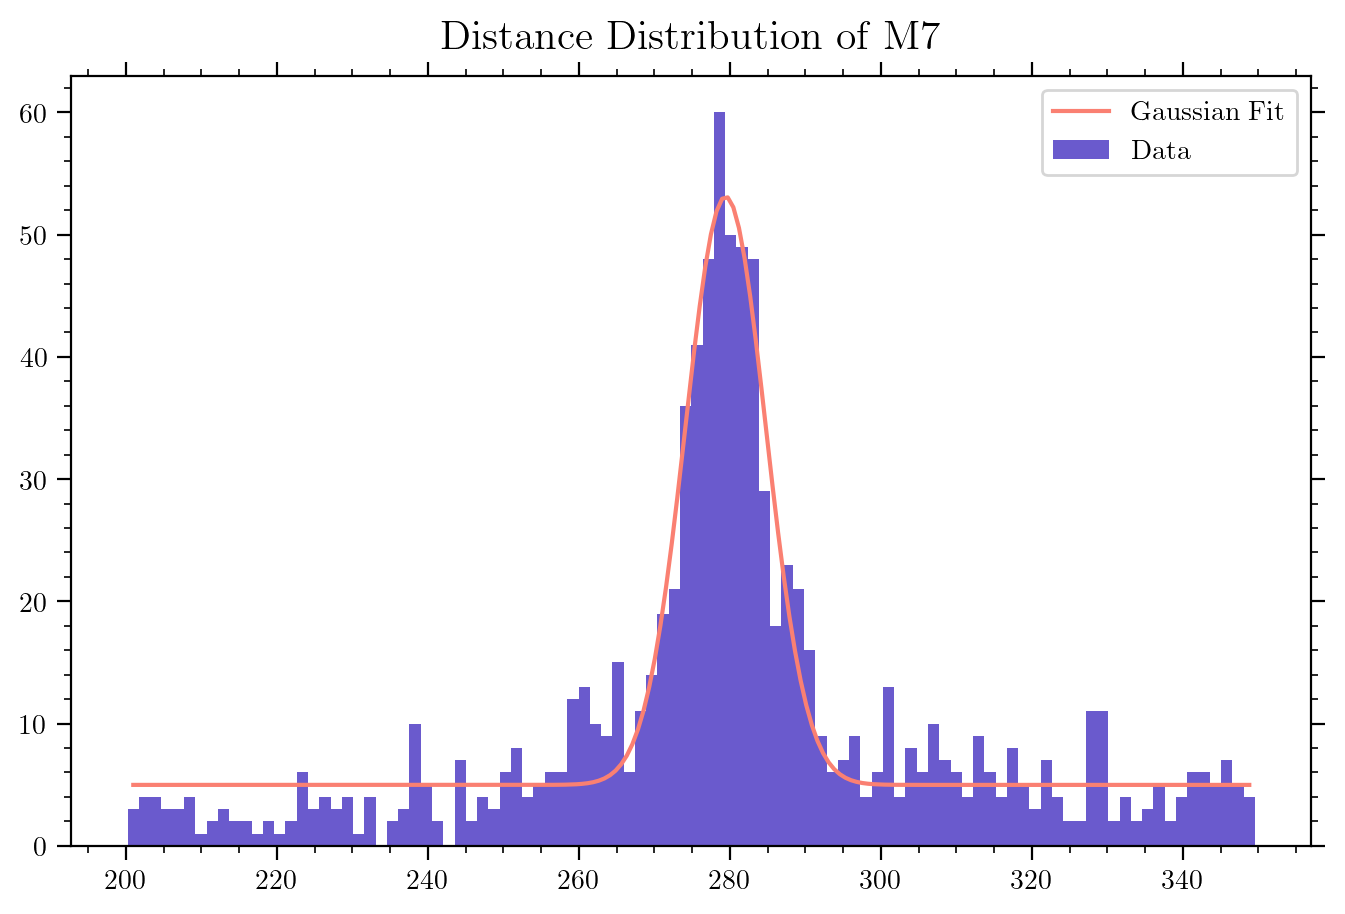

In [144]:
dist_m7 = dist_m7[np.logical_and(dist_m7<350, dist_m7>200)]
popt_m7 = gauss_fit('M7', dist_m7)

INFO: Query finished. [astroquery.utils.tap.core]


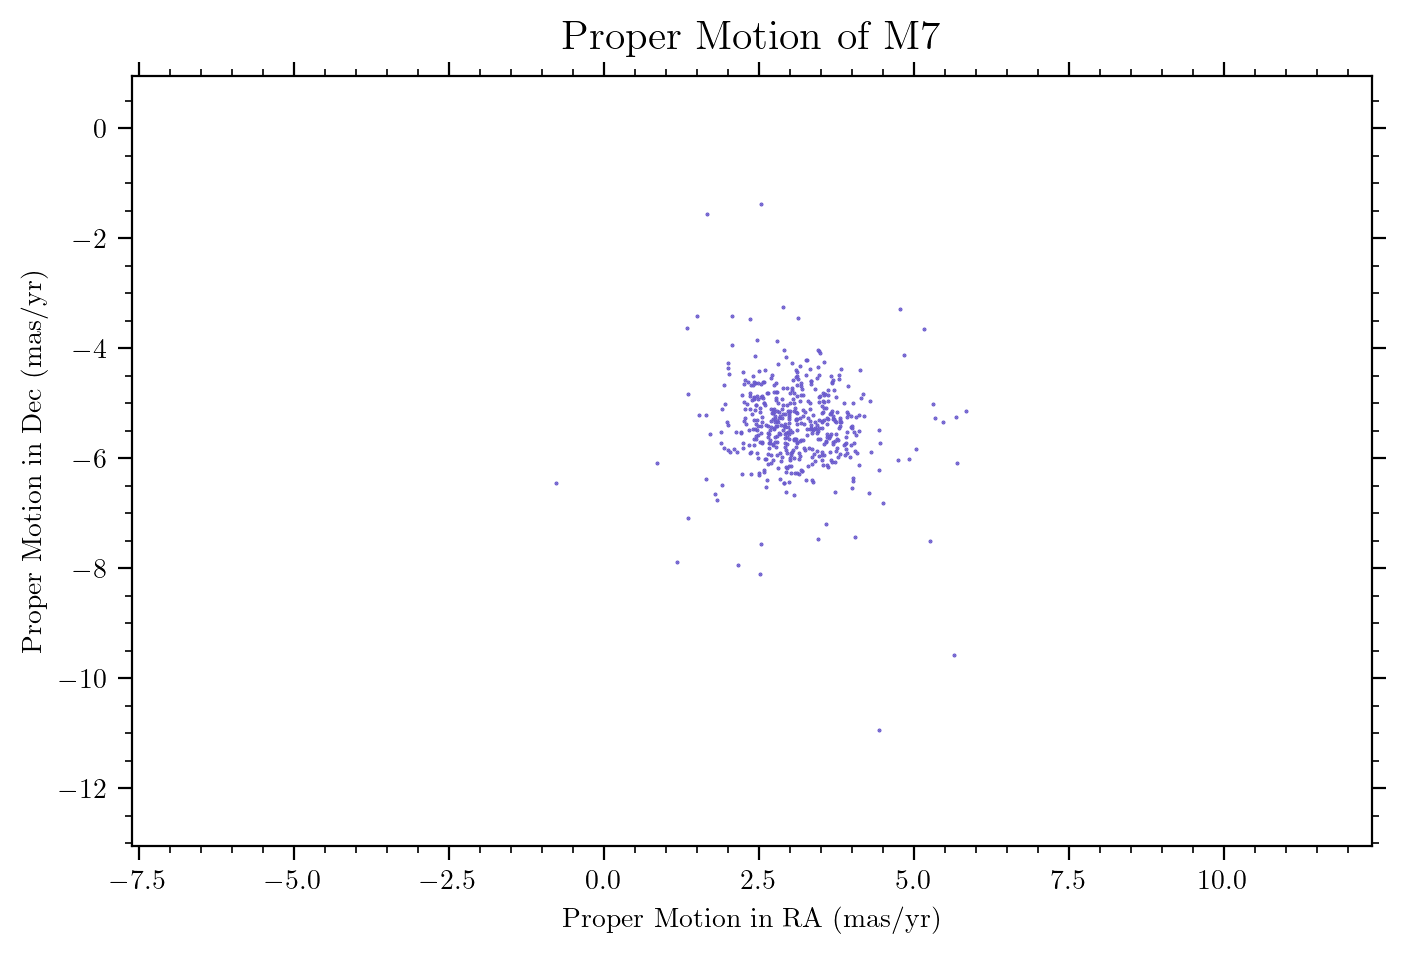

In [145]:
parallax_start_m7, parallax_end_m7 = parallax_cut(dist_m7, popt_m7)
r_m7_2 = plot_pm('M7', parallax_start_m7, parallax_end_m7, 1)

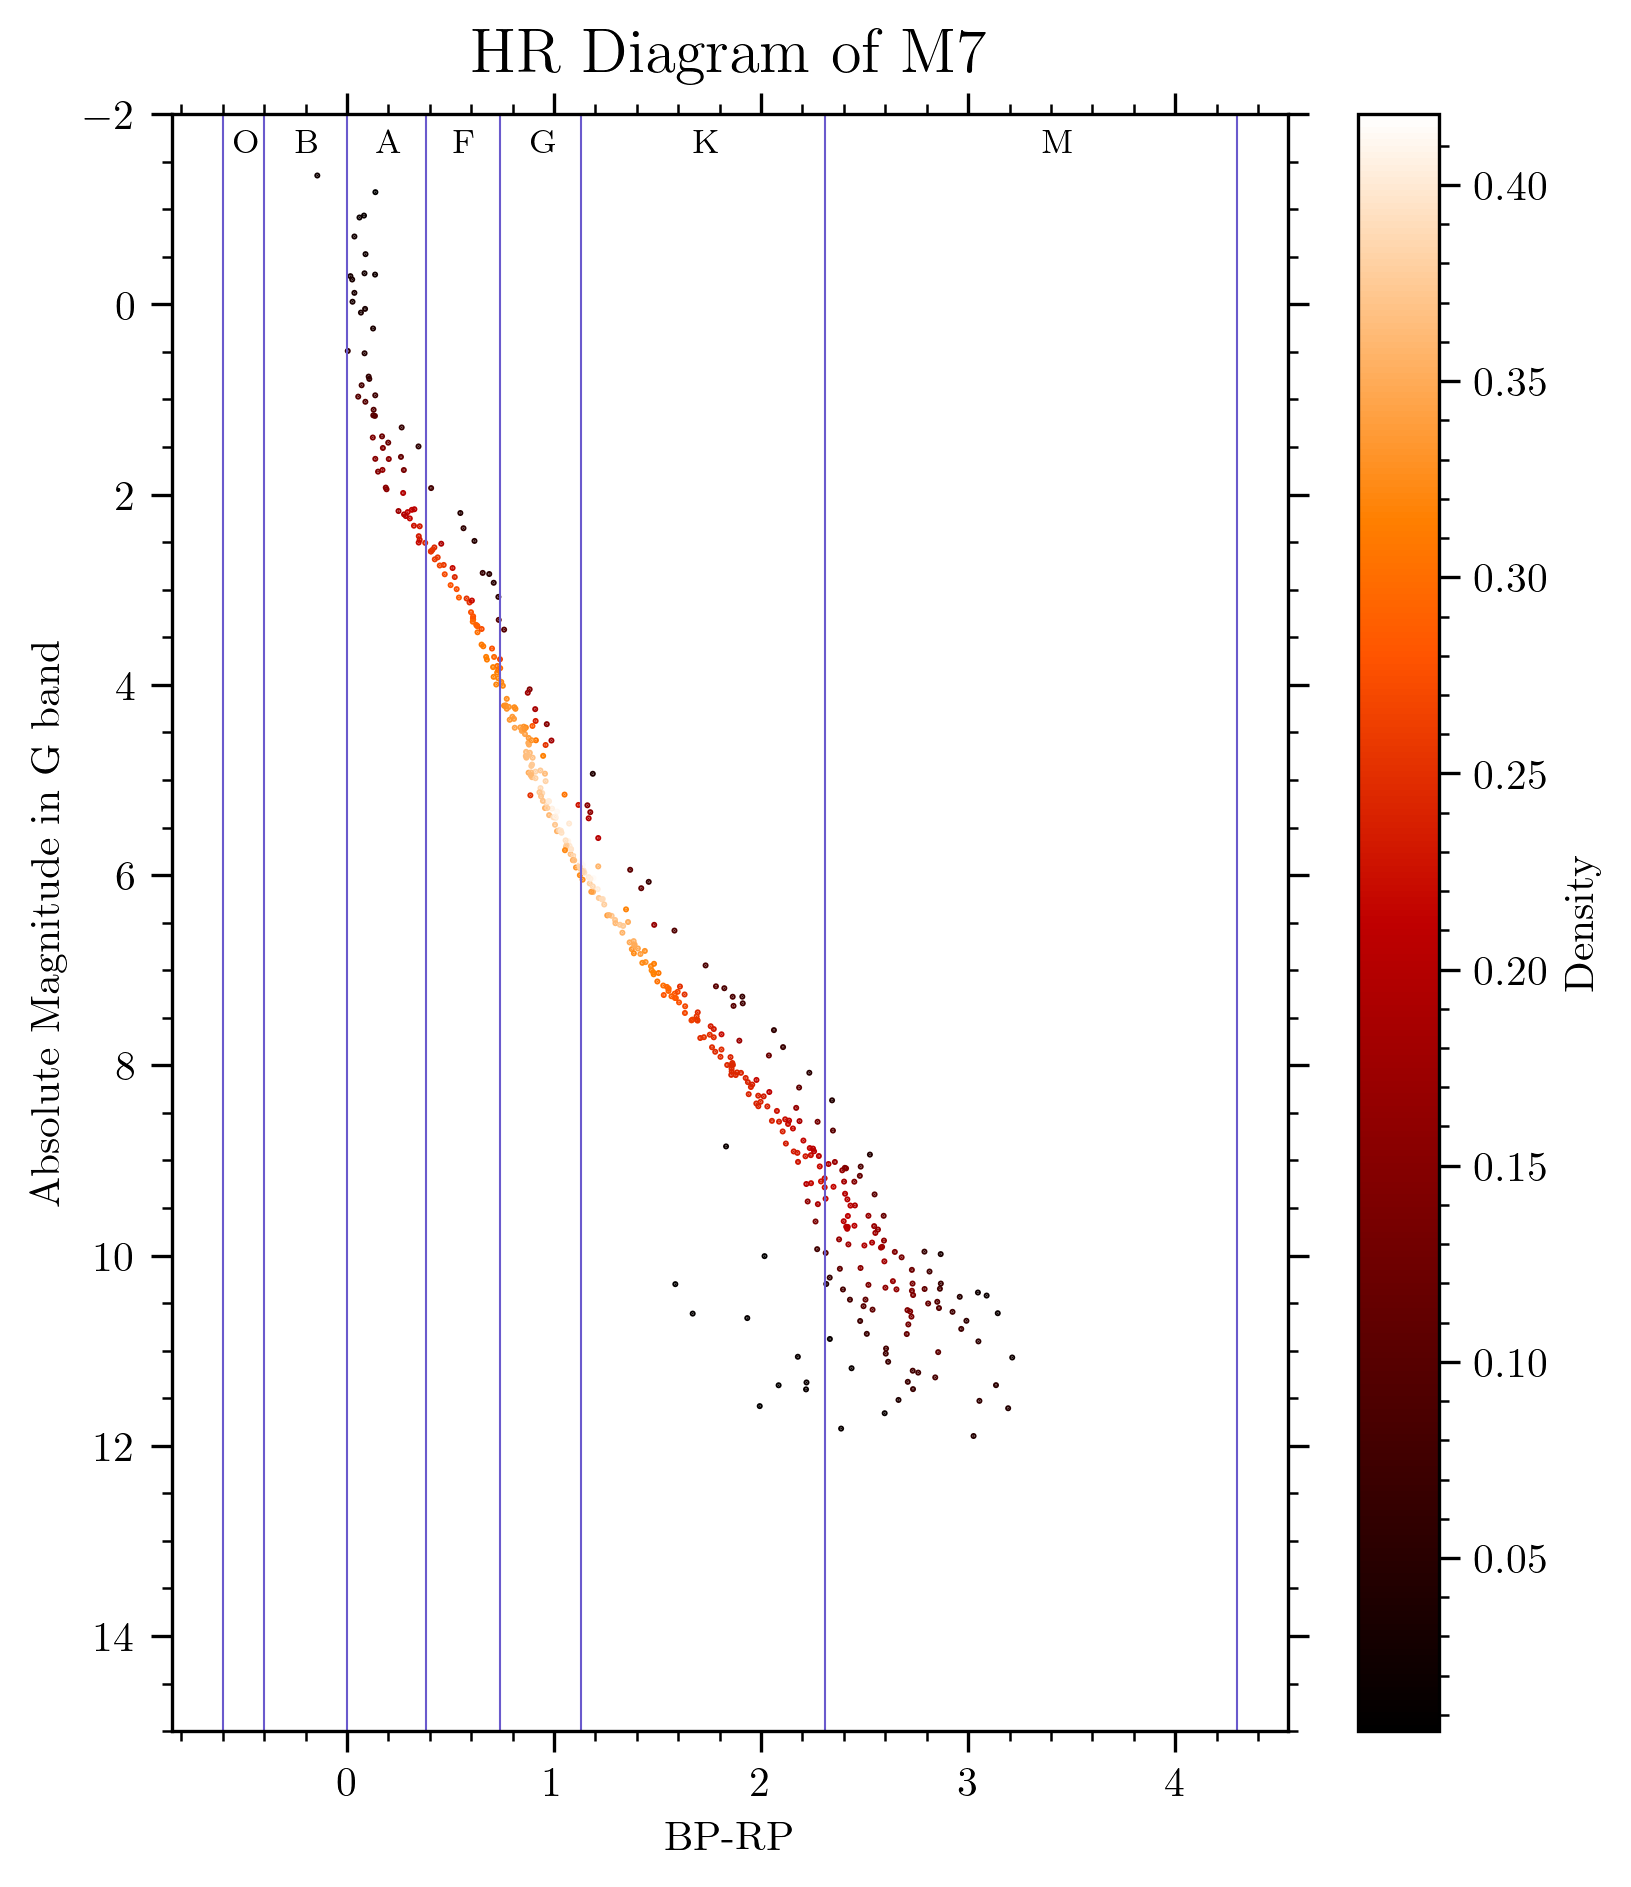

In [266]:
bprp_m7, _ = hr_diag('M7', r_m7_2)

In [267]:
perc_in_spec_class('M7', bprp_m7)

Percentage of O type stars in M7 is 0.0%
Percentage of B type stars in M7 is 0.21%
Percentage of A type stars in M7 is 11.16%
Percentage of F type stars in M7 is 10.95%
Percentage of G type stars in M7 is 20.84%
Percentage of K type stars in M7 is 35.58%
Percentage of M type stars in M7 is 21.26%


# **Messier 38**

INFO: Query finished. [astroquery.utils.tap.core]


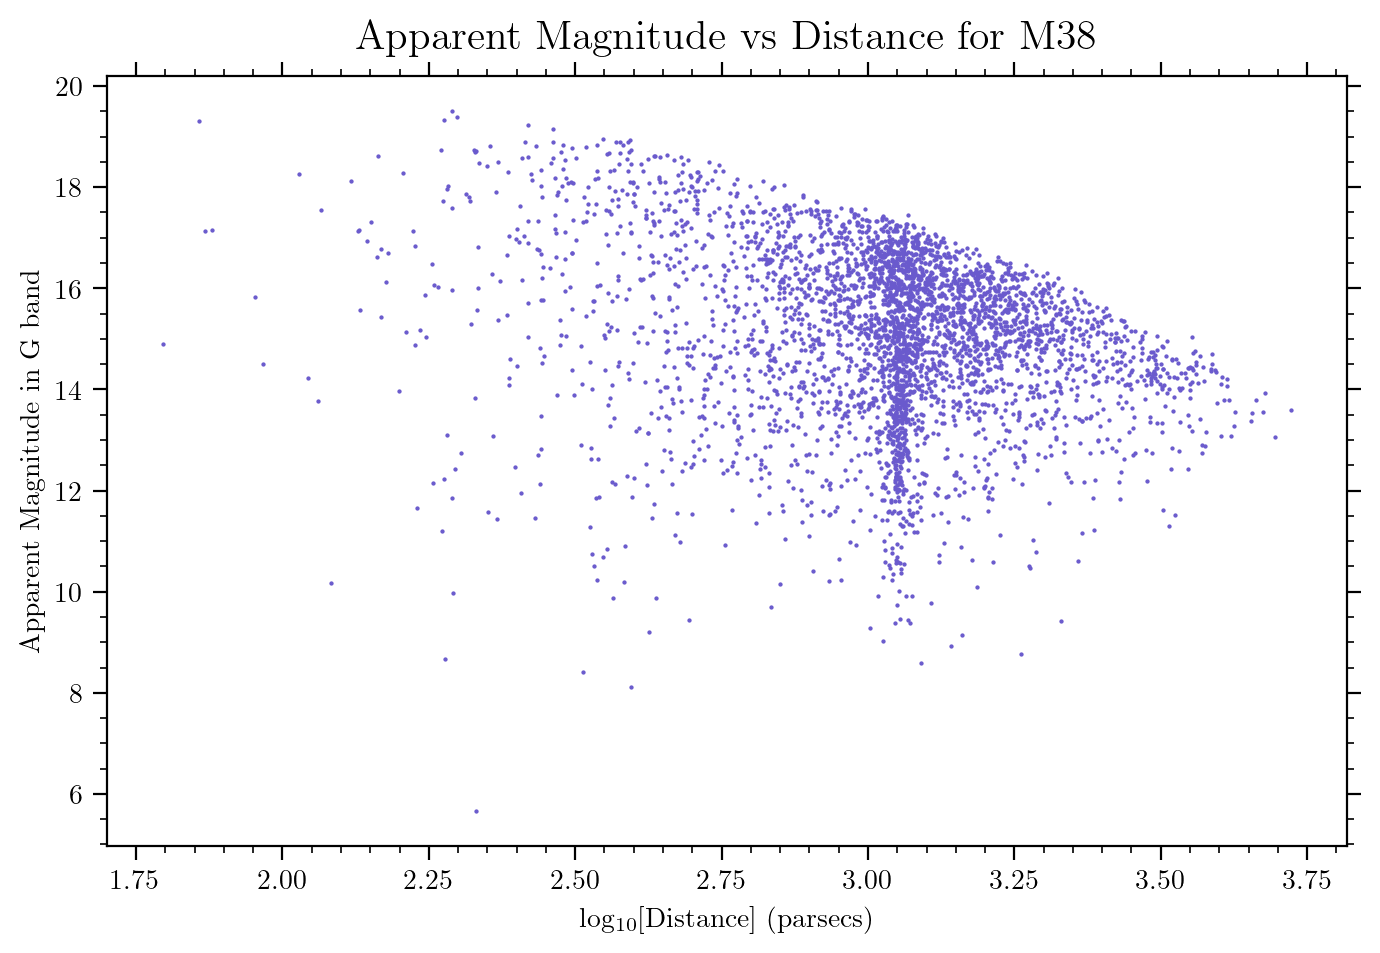

In [147]:
r_m38 = query_gaia('M38')
dist_m38 = plot_appmag_vs_dist('M38', r_m38)

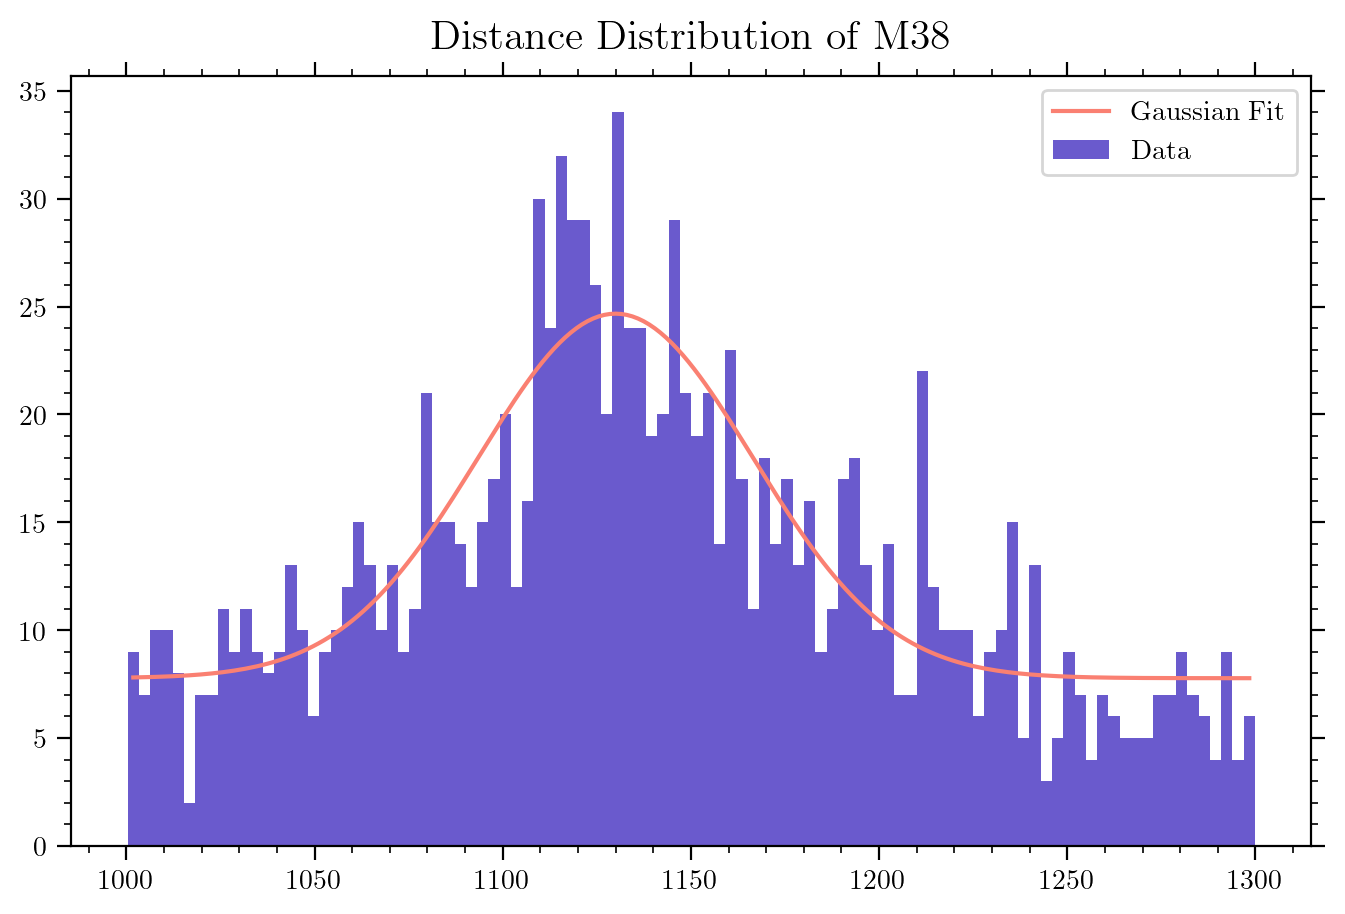

In [148]:
dist_m38 = dist_m38[np.logical_and(dist_m38<1300, dist_m38>1000)]
popt_m38 = gauss_fit('M38', dist_m38)

INFO: Query finished. [astroquery.utils.tap.core]


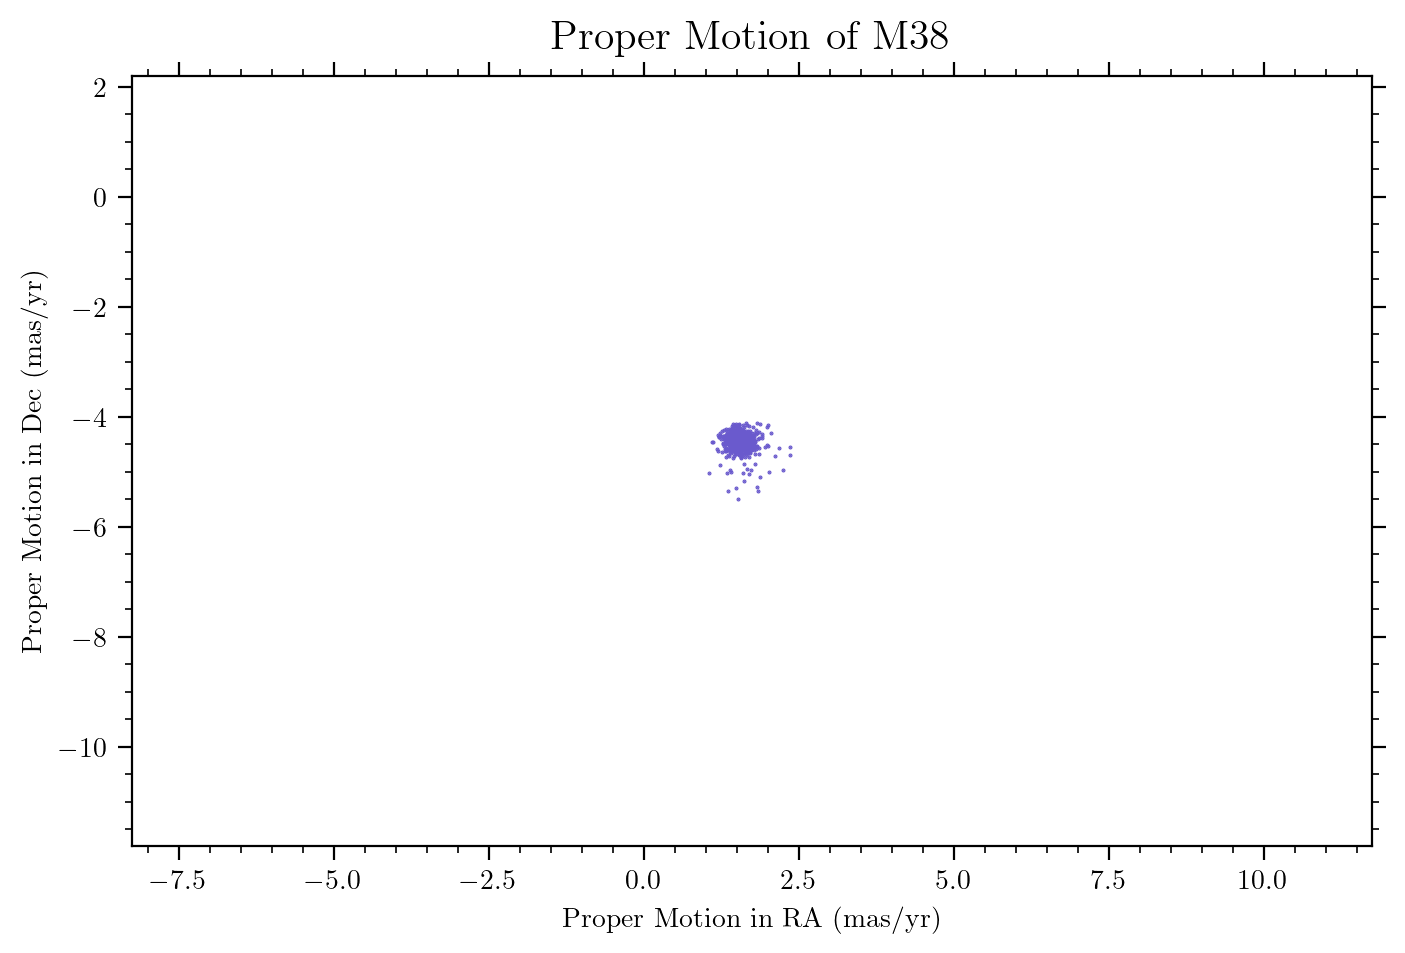

In [149]:
parallax_start_m38, parallax_end_m38 = parallax_cut(dist_m38, popt_m38)
r_m38_2 = plot_pm('M38', parallax_start_m38, parallax_end_m38, 0.2)

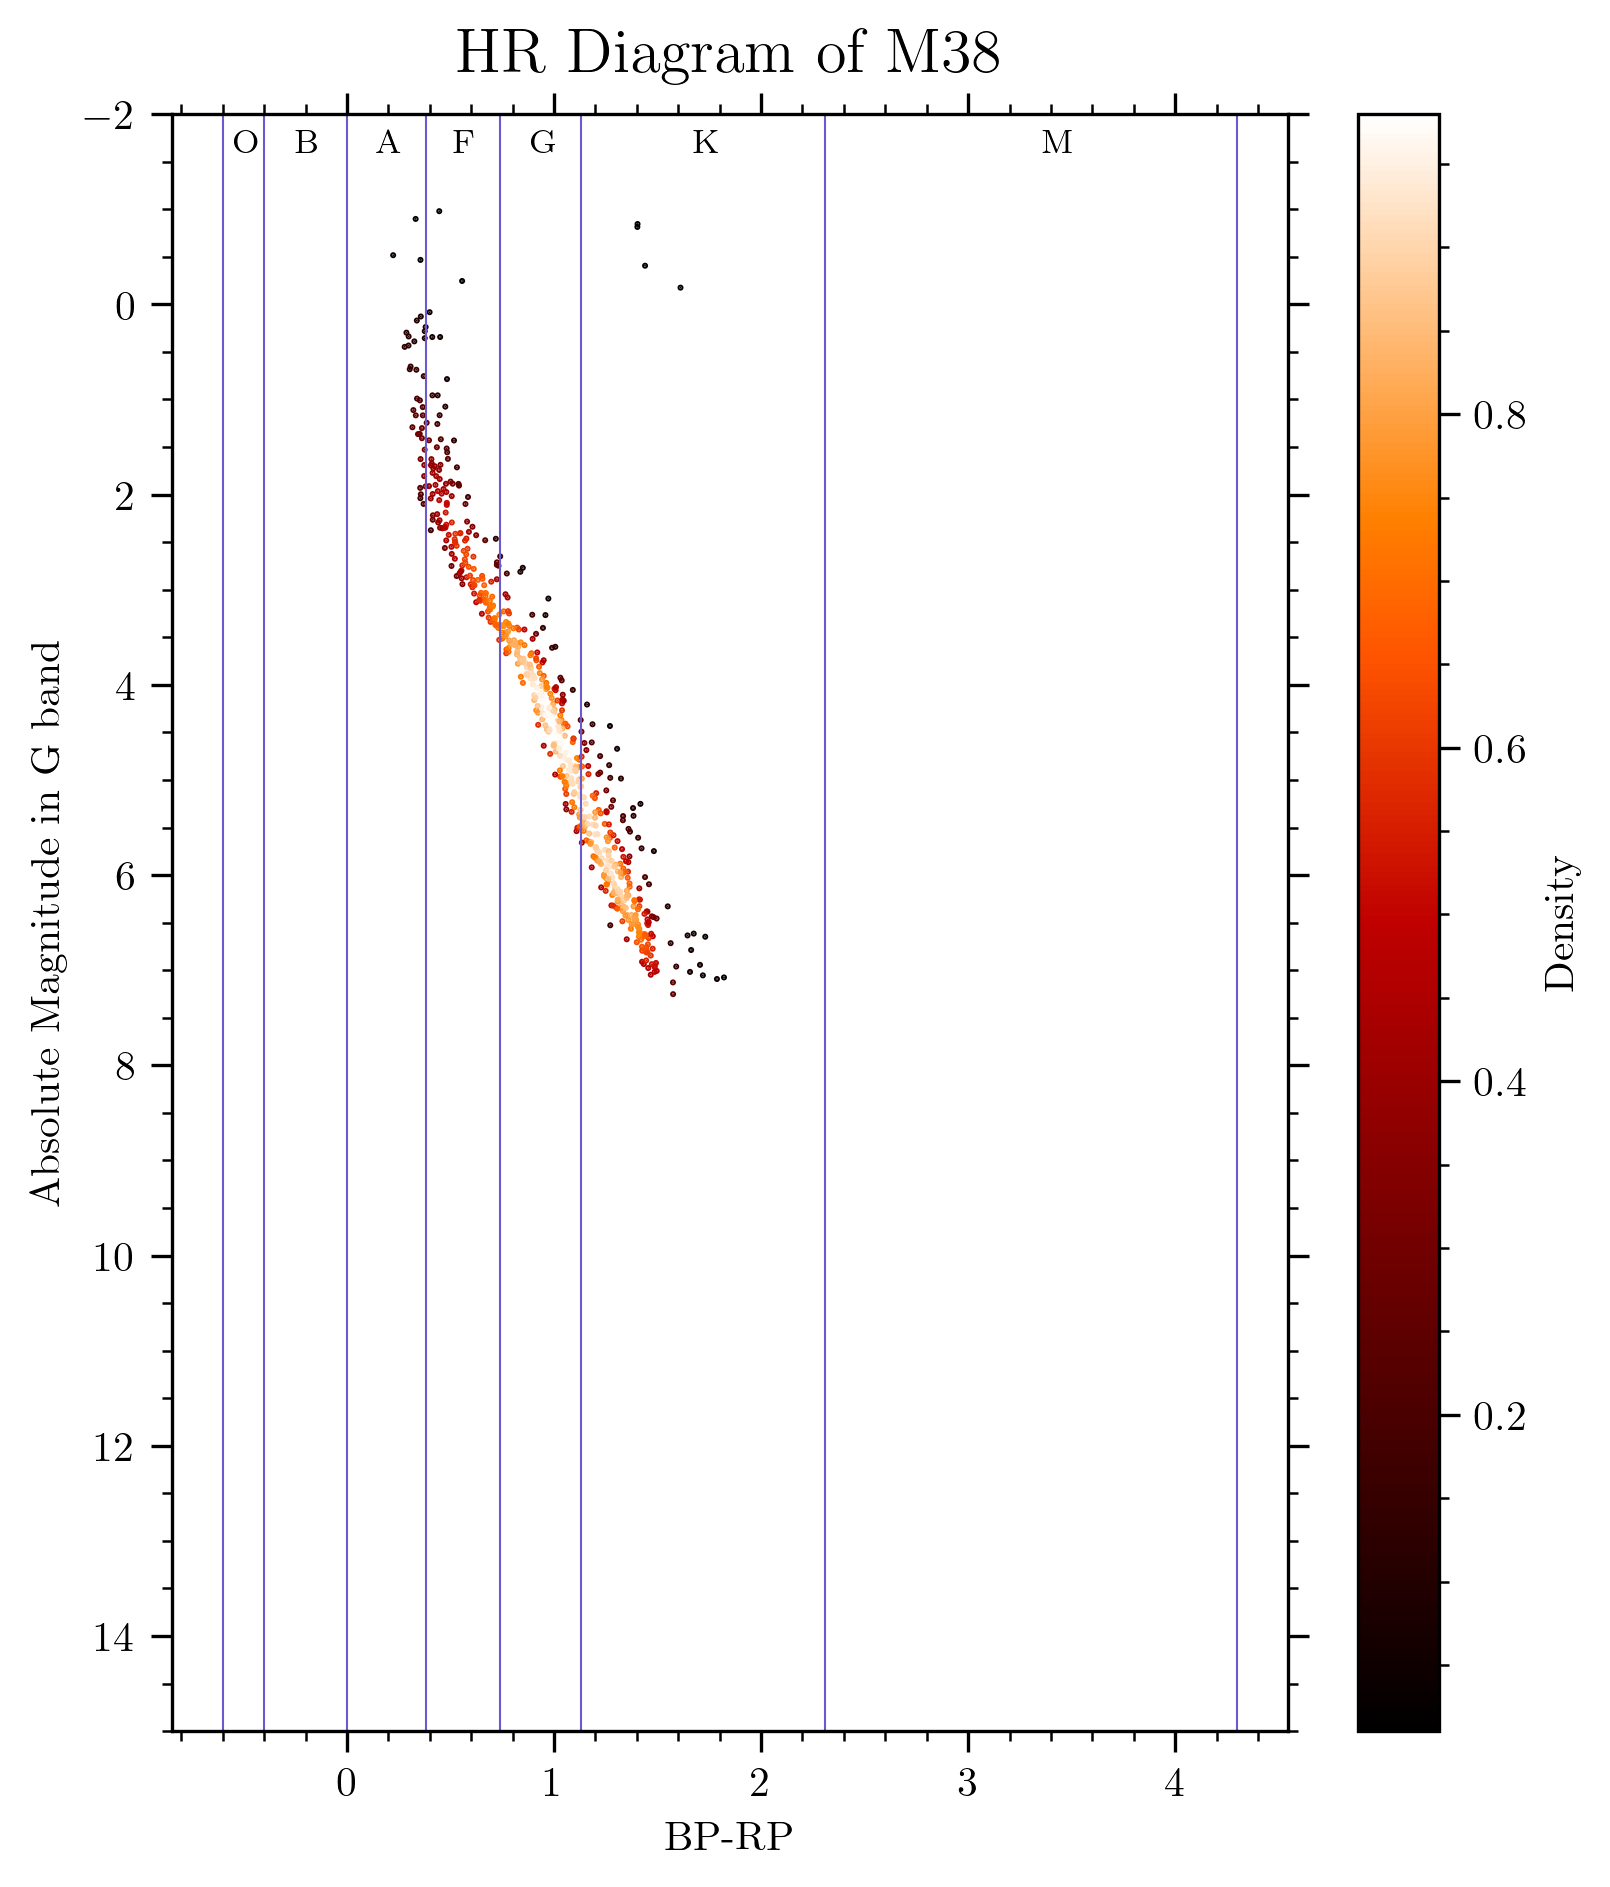

In [268]:
bprp_m38, _ = hr_diag('M38', r_m38_2)

In [269]:
perc_in_spec_class('M38', bprp_m38)

Percentage of O type stars in M38 is 0.0%
Percentage of B type stars in M38 is 0.0%
Percentage of A type stars in M38 is 5.69%
Percentage of F type stars in M38 is 23.08%
Percentage of G type stars in M38 is 34.31%
Percentage of K type stars in M38 is 36.92%
Percentage of M type stars in M38 is 0.0%


# **Lambda Orionis**

INFO: Query finished. [astroquery.utils.tap.core]


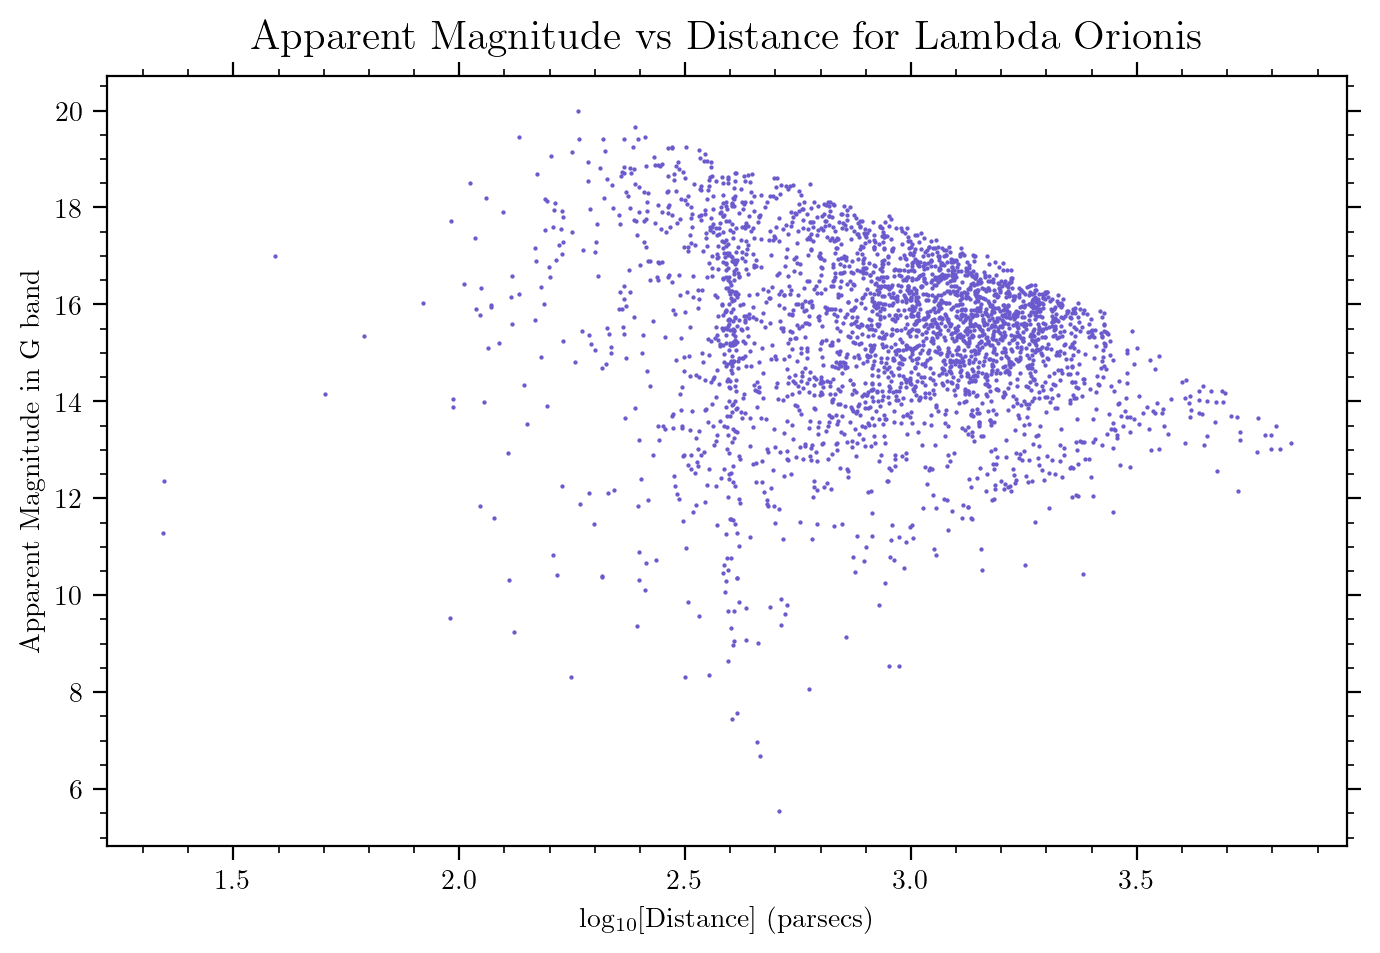

In [151]:
ra, dec = 83.784, 9.934
r_loc = query_gaia(ra=ra, dec=dec)
dist_loc = plot_appmag_vs_dist("Lambda Orionis", r_loc)

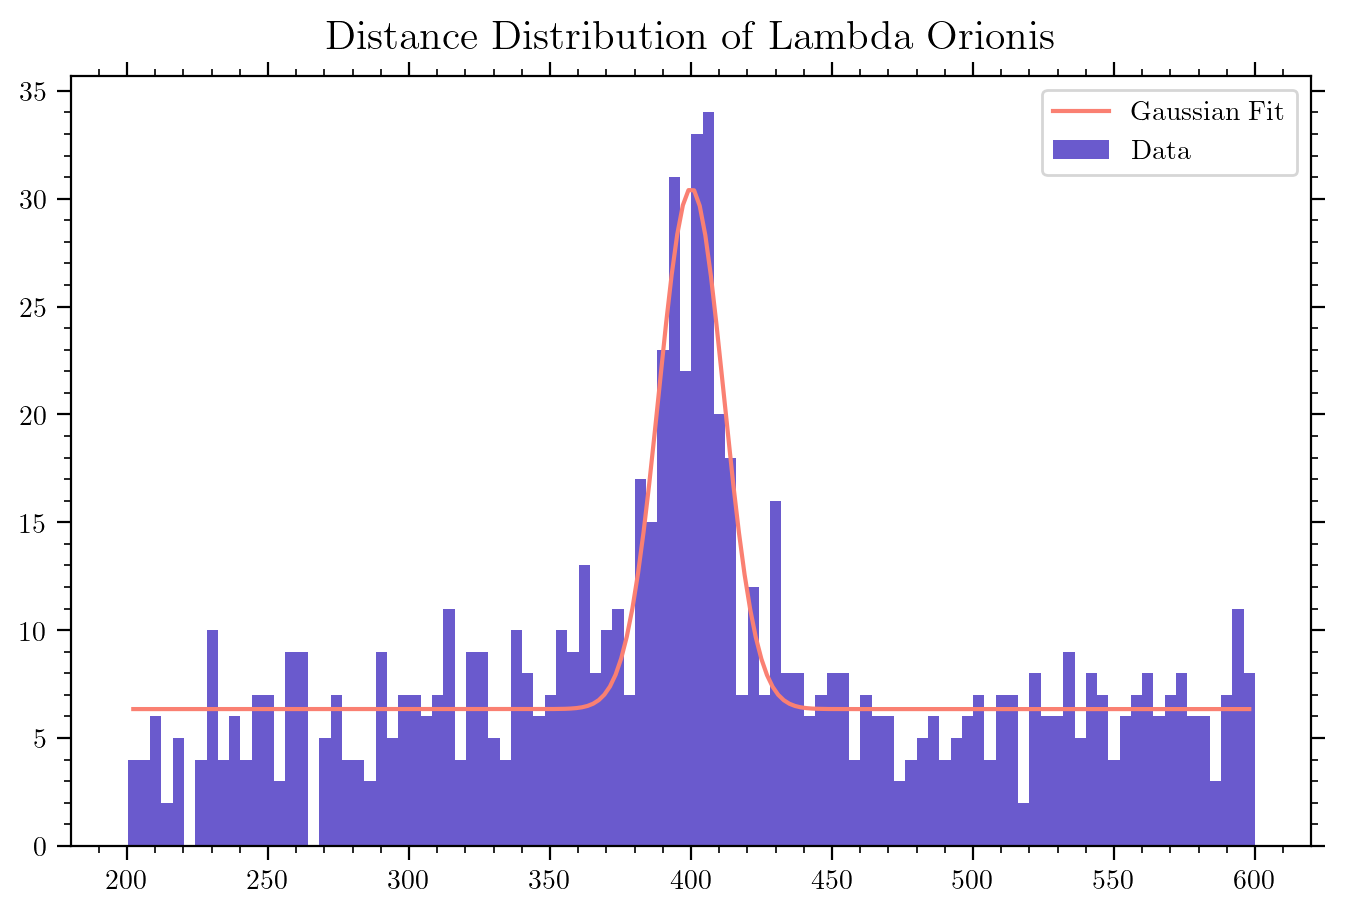

In [152]:
dist_loc = dist_loc[np.logical_and(dist_loc<600, dist_loc>200)]
popt_loc = gauss_fit("Lambda Orionis", dist_loc)

INFO: Query finished. [astroquery.utils.tap.core]


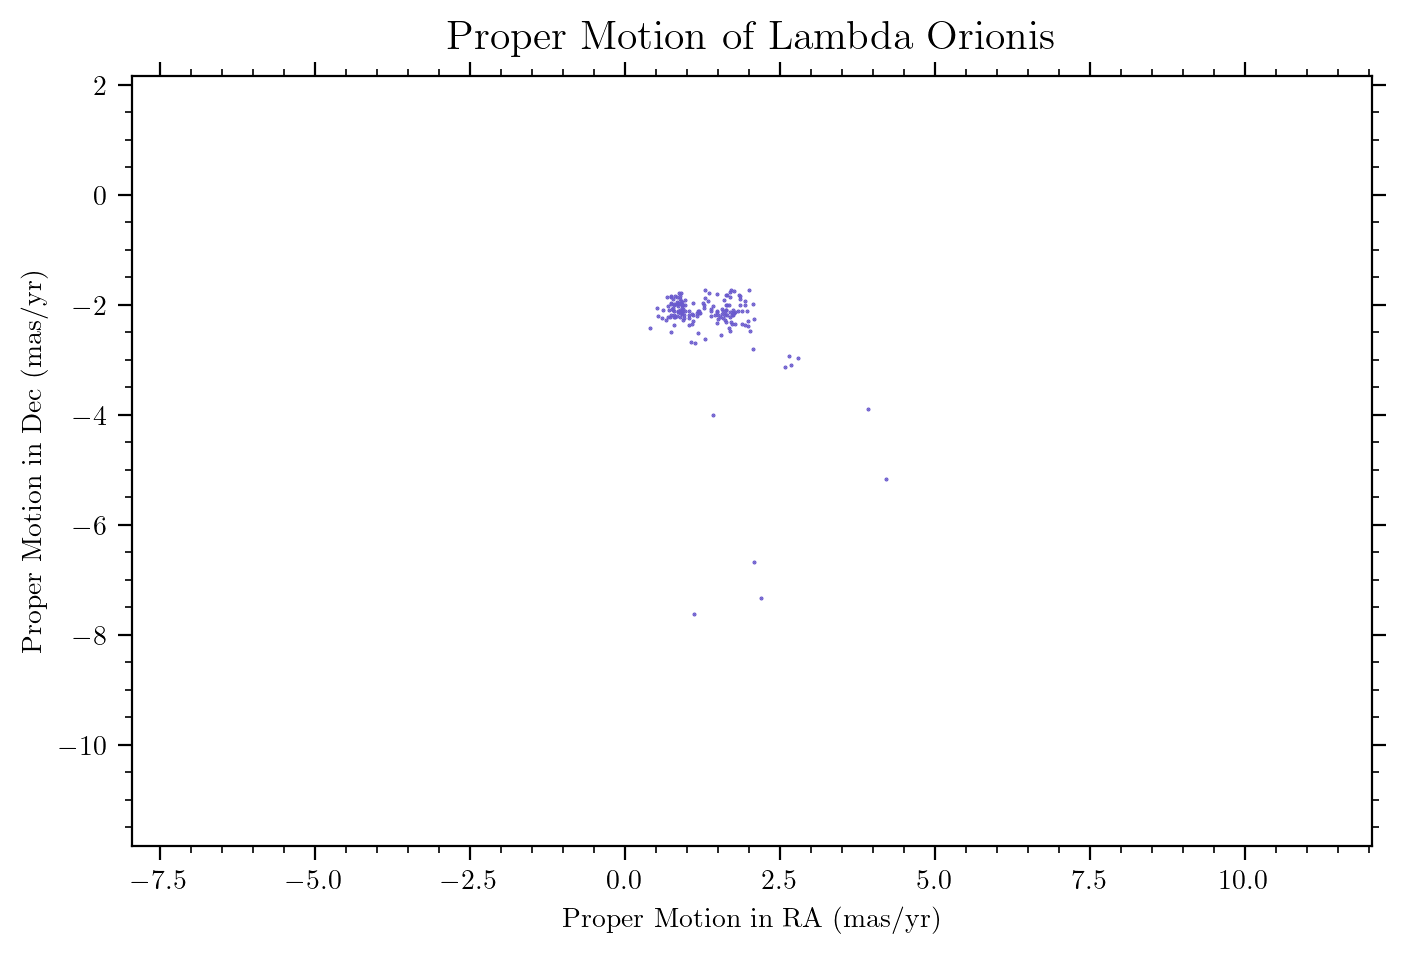

In [153]:
parallax_start_loc, parallax_end_loc = parallax_cut(dist_loc, popt_loc)
r_loc_2 = plot_pm("Lambda Orionis", parallax_start_loc, parallax_end_loc, 0.4, ra=ra, dec=dec)

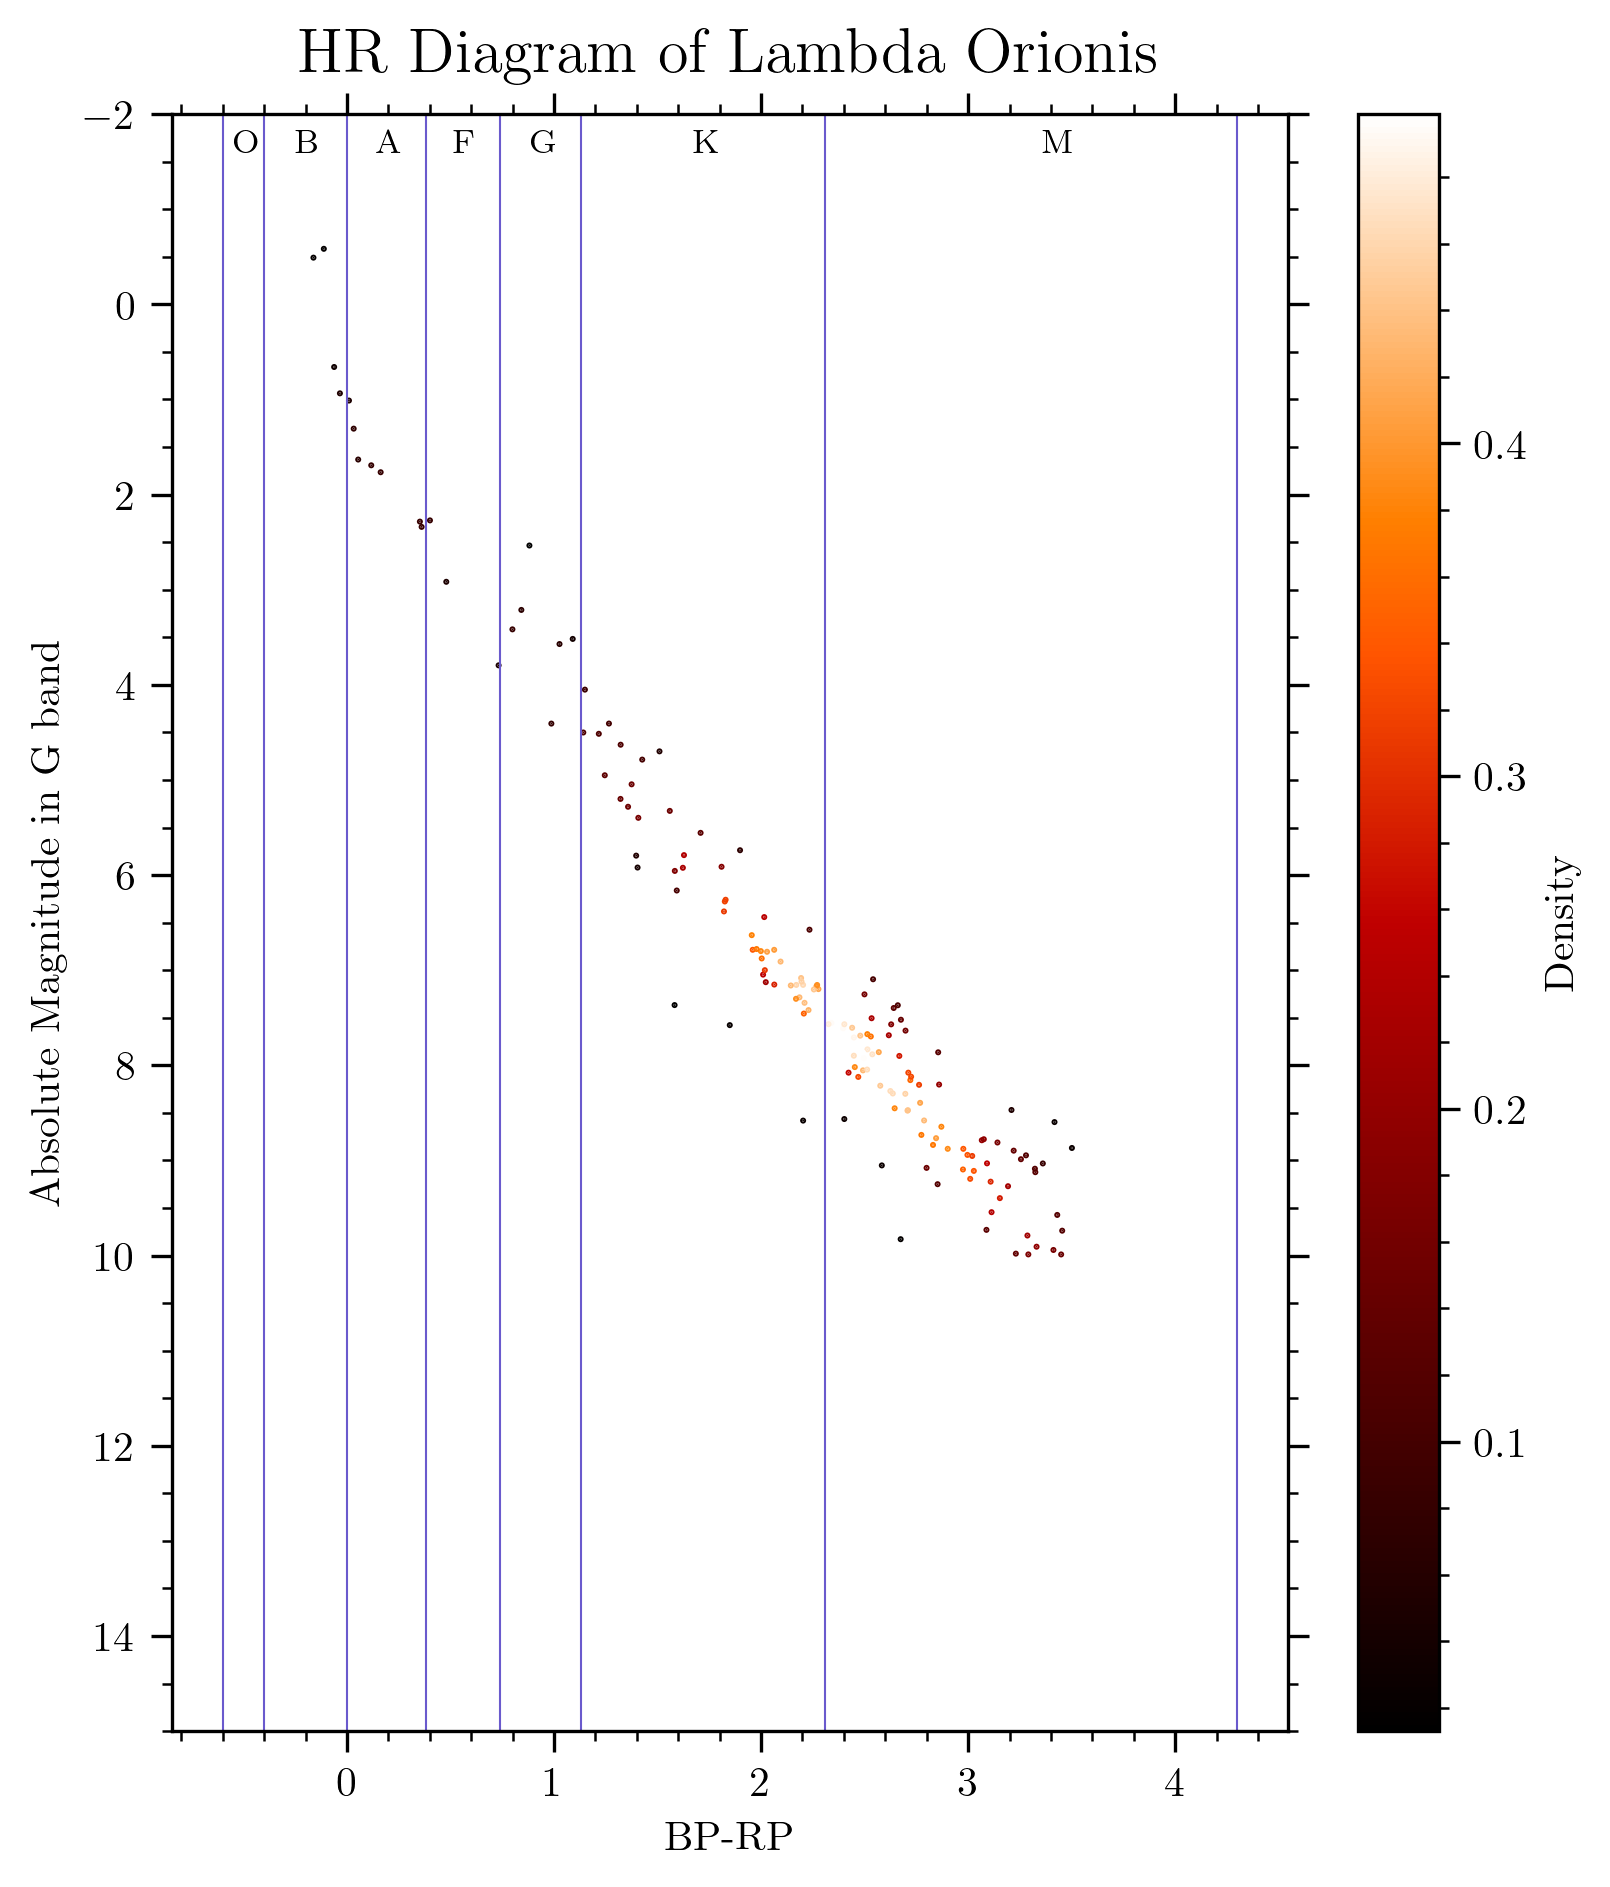

In [270]:
bprp_loc, _ = hr_diag("Lambda Orionis", r_loc_2)

In [271]:
perc_in_spec_class("Lambda Orionis", bprp_loc)

Percentage of O type stars in Lambda Orionis is 0.0%
Percentage of B type stars in Lambda Orionis is 2.44%
Percentage of A type stars in Lambda Orionis is 4.27%
Percentage of F type stars in Lambda Orionis is 1.83%
Percentage of G type stars in Lambda Orionis is 3.66%
Percentage of K type stars in Lambda Orionis is 34.15%
Percentage of M type stars in Lambda Orionis is 53.66%


# **Alpha Persei Cluster**

INFO: Query finished. [astroquery.utils.tap.core]


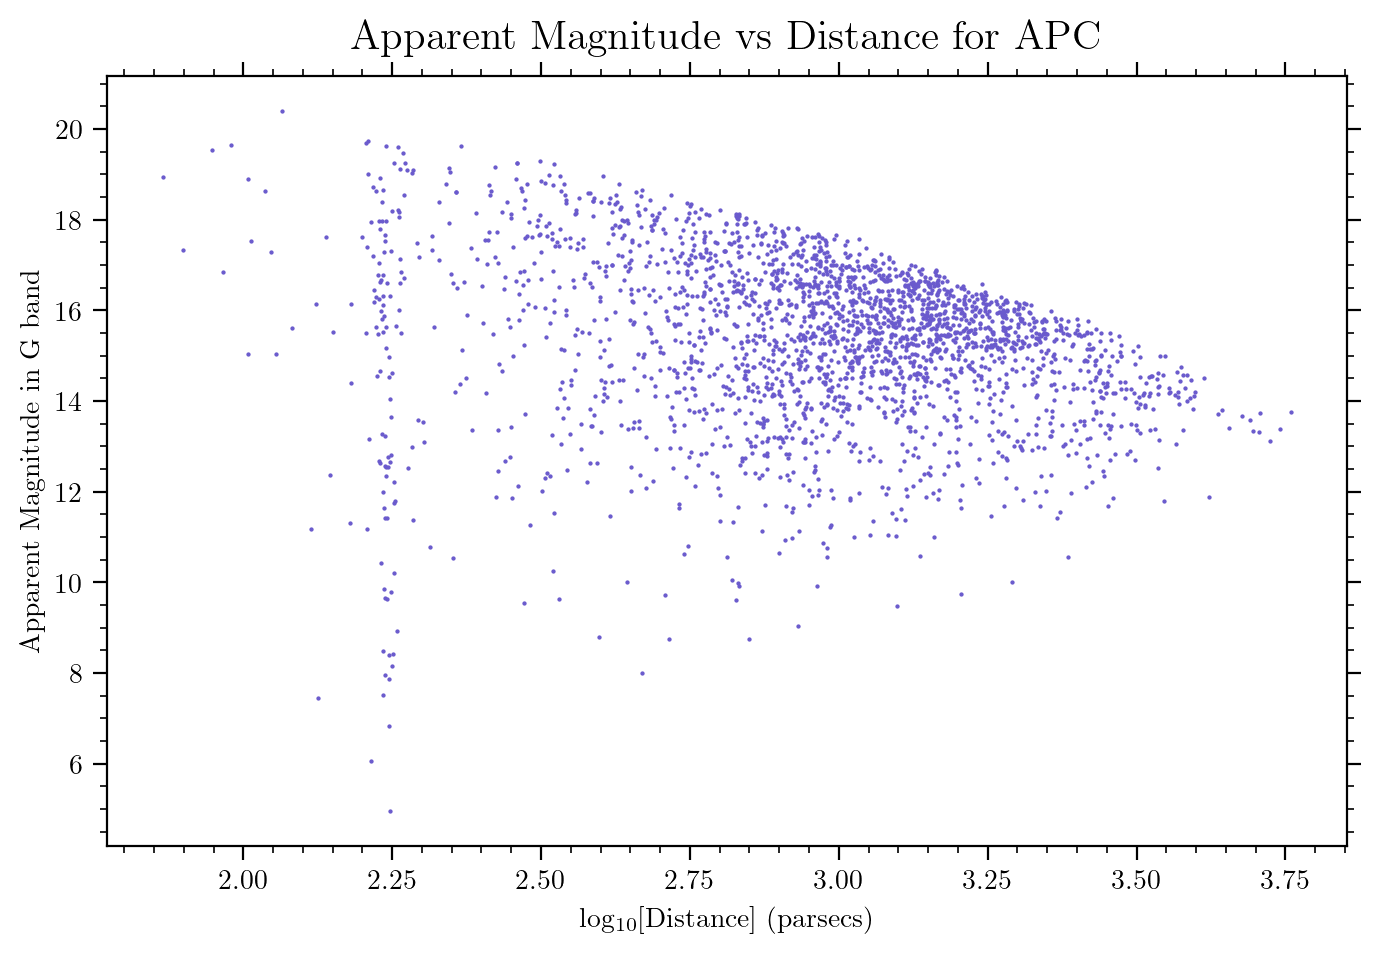

In [157]:
ra_apc, dec_apc = 51.675, 48.8
r_apc = query_gaia(ra = ra_apc, dec = dec_apc)
dist_loc_apc = plot_appmag_vs_dist("APC", r_apc)

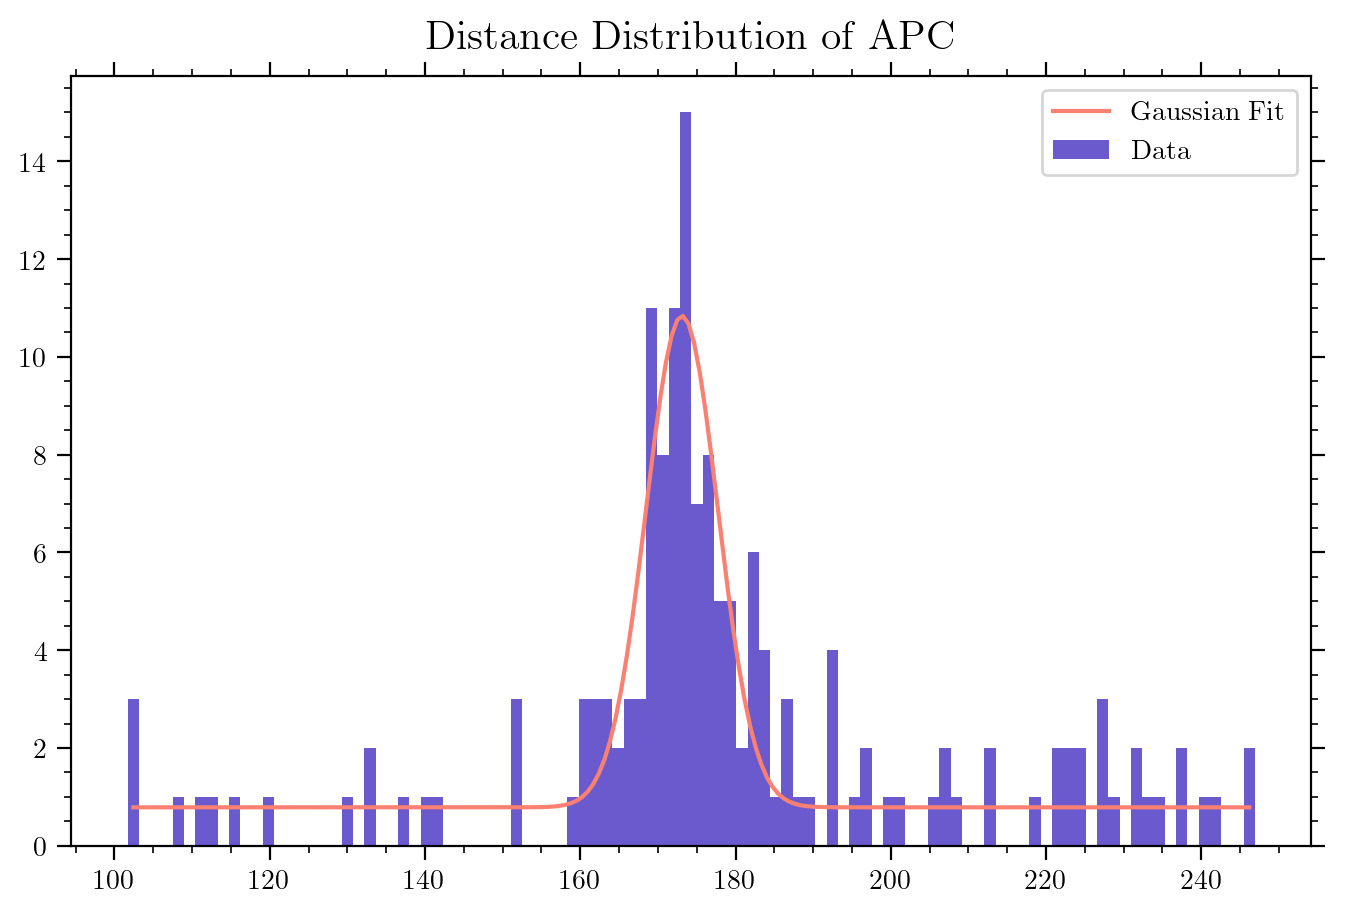

In [158]:
dist_loc_apc = dist_loc_apc[np.logical_and(dist_loc_apc<250, dist_loc_apc>100)]
popt_loc_apc = gauss_fit("APC", dist_loc_apc)

INFO: Query finished. [astroquery.utils.tap.core]


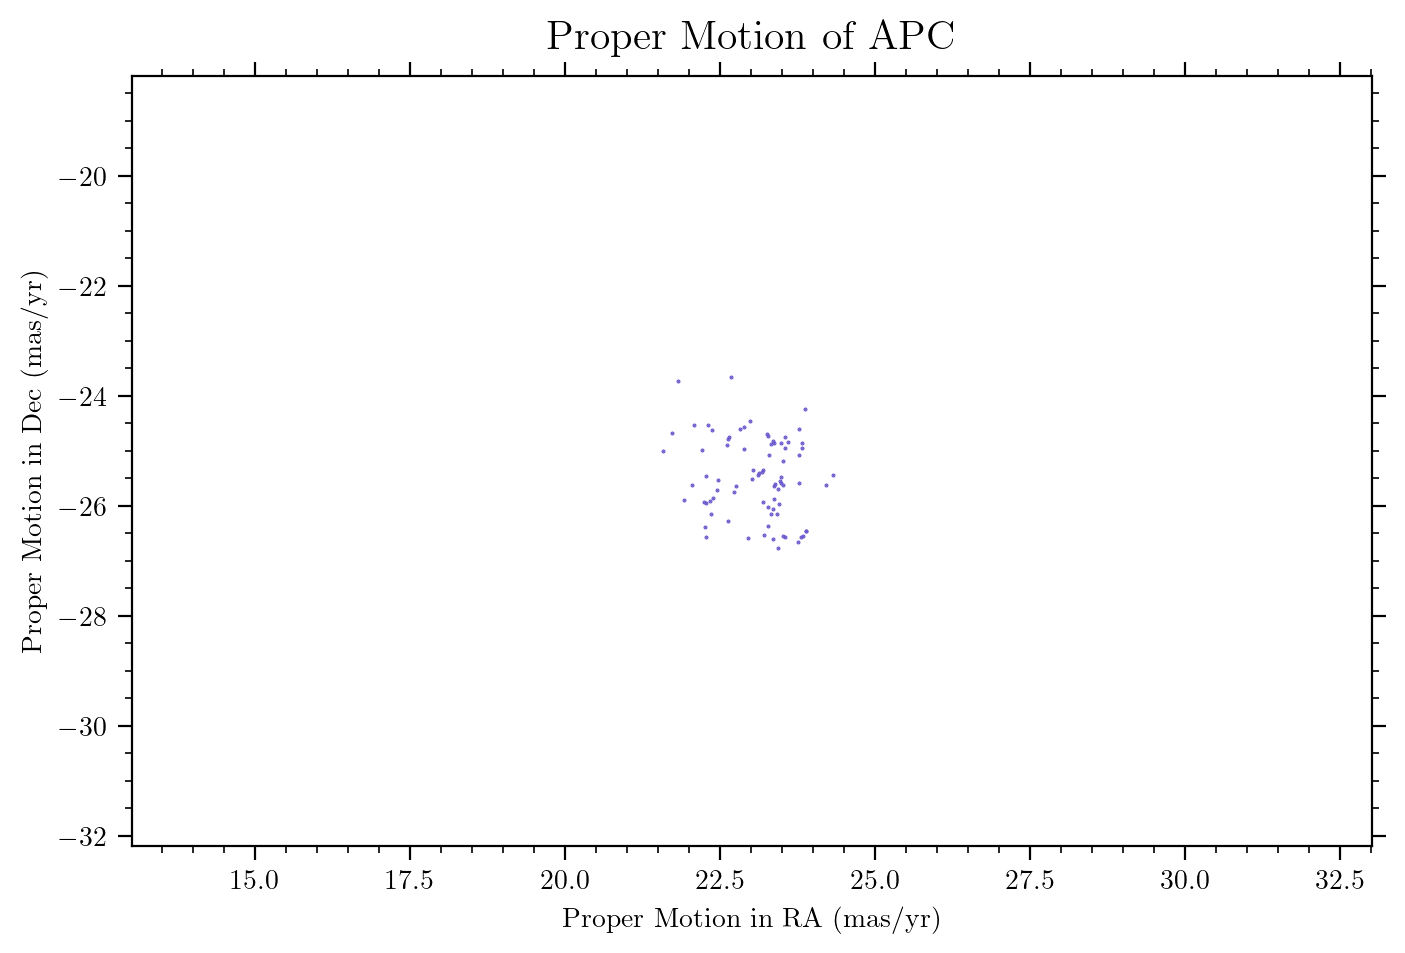

In [167]:
parallax_start_loc_apc, parallax_end_loc_apc = parallax_cut(dist_loc_apc, popt_loc_apc)
r_apc_2 = plot_pm("APC", parallax_start_loc_apc, parallax_end_loc_apc, 0.15, ra=ra_apc, dec=dec_apc)

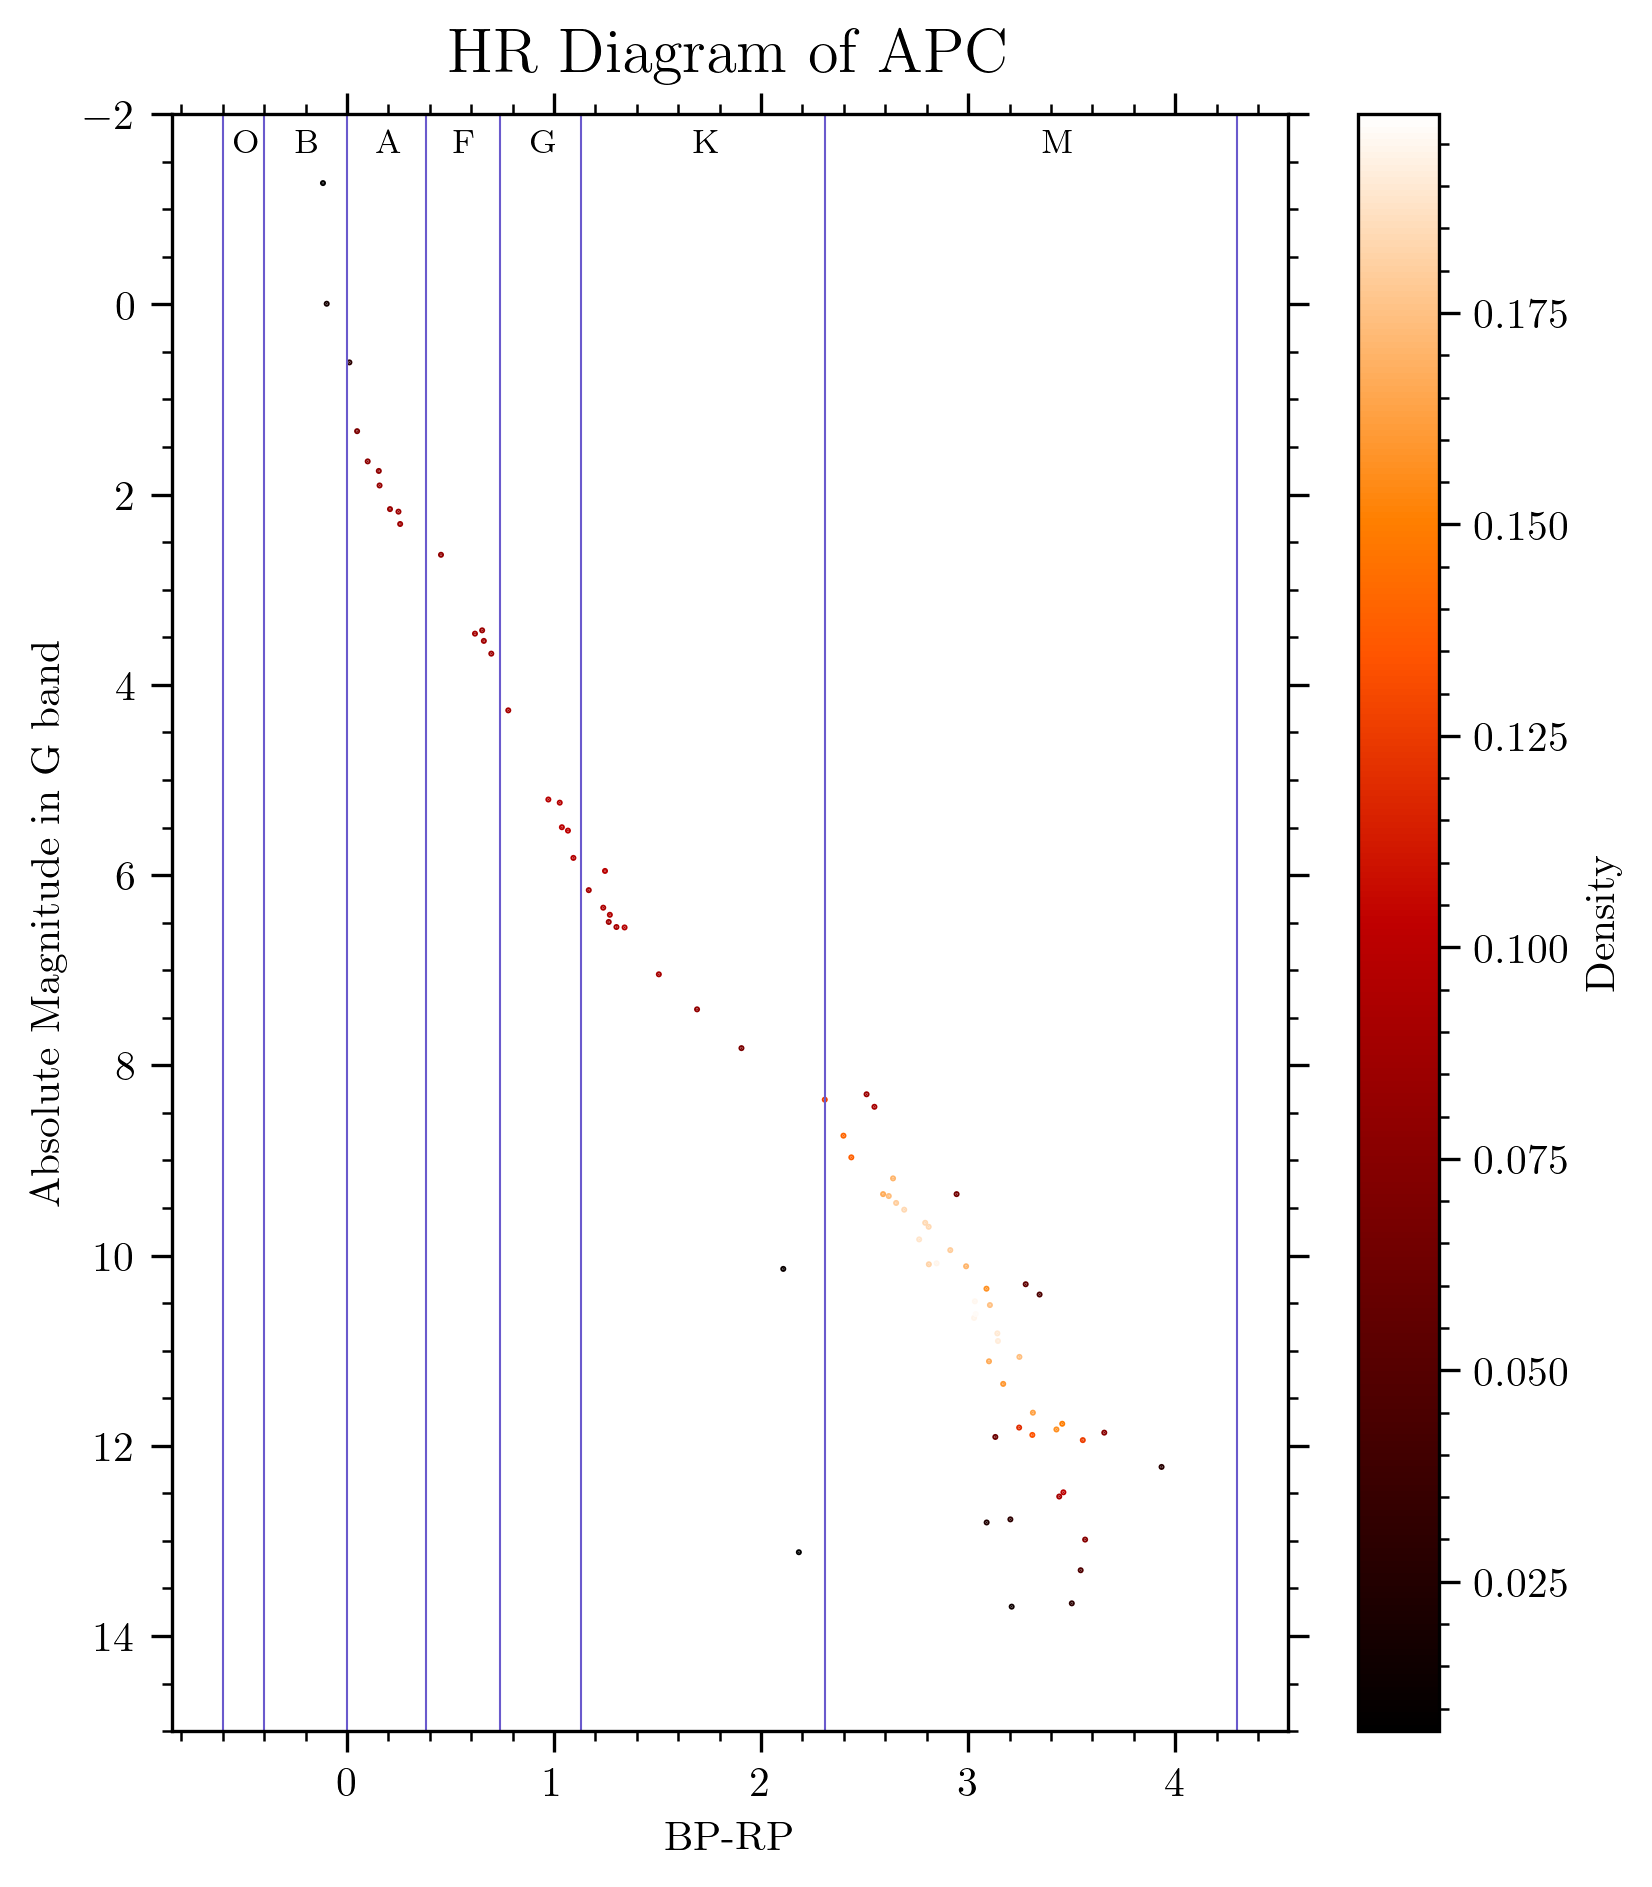

In [272]:
bprp_apc, _ = hr_diag("APC", r_apc_2)

In [273]:
perc_in_spec_class("APC", bprp_apc)

Percentage of O type stars in APC is 0.0%
Percentage of B type stars in APC is 2.47%
Percentage of A type stars in APC is 9.88%
Percentage of F type stars in APC is 6.17%
Percentage of G type stars in APC is 7.41%
Percentage of K type stars in APC is 16.05%
Percentage of M type stars in APC is 58.02%
